In [182]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [550]:
class NHL_Period_Data:
    def __init__(self, dataFile="data/periodCombined.txt"):
        self.data_x, self.data_y = self.__parseData__(dataFile)
        self.train_x = None
        self.train_p1_x = None
        self.train_p2_x = None
        self.train_p3_x = None
        self.train_p4_x = None
        self.train_y = None
        self.train_p1_y = None
        self.train_p2_y = None
        self.train_p3_y = None
        self.train_p4_y = None
        self.test_x = None
        self.test_p1_x = None
        self.test_p2_x = None
        self.test_p3_x = None
        self.test_p4_x = None
        self.test_y = None
        self.test_p1_y = None
        self.test_p2_y = None
        self.test_p3_y = None
        self.test_p4_y = None
        
    def __parseData__(self, dataFile):
        #data = np.genfromtxt(dataFile, delimiter=",", dtype=[int,int,int,int,int,int,int,int,int,
        #                                                     int,int,int,int,int,int,int,int,int,
        #                                                     'float64','float64',int], skip_header=1)
        data = np.genfromtxt(dataFile, delimiter=",", dtype='float64', skip_header=1)
        return data[...,0:-1],data[...,-1].astype(int)
    
    def transformData(self, encoder="StandardScaler",cols=None):
        if cols is None:
            cols = list(range(len(self.data_x[0])))
        col_tr = ColumnTransformer([(encoder, getattr(preprocessing,encoder)(),cols)])
        col_tr.fit(self.data_x, self.data_y)
        self.data_x = col_tr.transform(self.data_x)
    
    def transformPeriodData(self, encoder="StandardScaler", cols=None):
        if cols is None:
            cols = list(range(len(self.p1_data_x[0])))

        i = 1
        for data_x, data_y in zip([self.p1_data_x,self.p2_data_x,self.p3_data_x,self.pOT_data_x],
                                  [self.p1_data_y,self.p2_data_y,self.p3_data_y,self.pOT_data_y]):            
            col_tr = ColumnTransformer([(encoder, getattr(preprocessing,encoder)(),cols)])
            col_tr.fit(data_x, data_y)
            if i == 1:
                self.train_p1_x = col_tr.transform(self.train_p1_x)
                self.test_p1_x = col_tr.transform(self.test_p1_x)
            if i == 2:
                self.train_p2_x = col_tr.transform(self.train_p2_x)
                self.test_p2_x = col_tr.transform(self.test_p2_x)
            if i == 3:
                self.train_p3_x = col_tr.transform(self.train_p3_x)
                self.test_p3_x = col_tr.transform(self.test_p3_x)
            if i == 4:
                self.train_p4_x = col_tr.transform(self.train_p4_x)
                self.test_p4_x = col_tr.transform(self.test_p4_x)
            i+=1
        
    def trainTestSplit(self, split=0.2, period=None):
        self.train_p1_x,self.test_p1_x,self.train_p1_y,self.test_p1_y = \
            train_test_split(self.p1_data_x, self.p1_data_y, test_size=split)
        
        self.train_p2_x,self.test_p2_x,self.train_p2_y,self.test_p2_y = \
            train_test_split(self.p2_data_x, self.p2_data_y, test_size=split)

        self.train_p3_x,self.test_p3_x,self.train_p3_y,self.test_p3_y = \
            train_test_split(self.p3_data_x, self.p3_data_y, test_size=split)
        
        self.train_p4_x,self.test_p4_x,self.train_p4_y,self.test_p4_y = \
            train_test_split(self.pOT_data_x, self.pOT_data_y, test_size=split)
        
        self.train_x,self.test_x,self.train_y,self.test_y = \
            train_test_split(self.data_x[...,1:], self.data_y, test_size=split)
        
    def combineHomeAwayFeatures(self):
        home_away = [[3,2],[5,4],[7,6],[9,8],[11,10],[13,12],[15,14],[17,16],[18,19]]
        combined = np.zeros((len(self.data_x),11))
        combined[...,0] = self.data_x[...,0]
        combined[...,1] = self.data_x[...,1]

        pos = 2
        for i in home_away:
            combined[...,pos] = self.data_x[...,i[0]] - self.data_x[...,i[1]]
            pos += 1
        self.data_comb_x = combined
        
    def selectKBest(self, k=10):
        selector = SelectKBest(k=k).fit(self.train_x, self.train_y)
        self.train_x = selector.transform(self.train_x)
        self.test_x = selector.transform(self.test_x)
        
    def chooseColumns(self, cols):
        self.train_xc = self.train_x[...,cols]
        self.train_p1_xc = self.train_p1_x[...,cols]
        self.train_p2_xc = self.train_p2_x[...,cols]
        self.train_p3_xc = self.train_p3_x[...,cols]
        self.train_p4_xc = self.train_p4_x[...,cols]
        self.test_p1_xc = self.test_p1_x[...,cols]
        self.test_p2_xc = self.test_p2_x[...,cols]
        self.test_p3_xc = self.test_p3_x[...,cols]
        self.test_p4_xc = self.test_p4_x[...,cols]
        
    def binScores(self, max_bin=4, min_bin=-4):
        if self.train_y is not None:
            self.train_y = np.where(self.train_y > max_bin, max_bin, self.train_y)
            self.train_y = np.where(self.train_y < min_bin, min_bin, self.train_y)
            self.test_y = np.where(self.test_y > max_bin, max_bin, self.test_y)
            self.test_y = np.where(self.test_y < min_bin, min_bin, self.test_y)
        else:
            self.data_y = np.where(self.data_y > max_bin, max_bin, self.data_y)
            self.data_y = np.where(self.data_y < min_bin, min_bin, self.data_y)
    
    def splitByPeriod(self, comb=False):
        if comb:
            data_x = self.data_comb_x
        else:
            data_x = self.data_x
        p1x = []
        p2x = []
        p3x = []
        pox = []
        p1y = []
        p2y = []
        p3y = []
        poy = []
        for i,x in enumerate(data_x):
            p = x[0].astype(int)%10
            y = self.data_y[i]
            if p == 1:
                p1x.append(x[1:])
                p1y.append(y)
            elif p == 2:
                p2x.append(x[1:])
                p2y.append(y)
            elif p == 3:
                p3x.append(x[1:])
                p3y.append(y)
            else:
                pox.append(x[1:])
                poy.append(y)
                
        self.p1_data_x = np.array(p1x)
        self.p1_data_y = np.array(p1y)
        self.p2_data_x = np.array(p2x)
        self.p2_data_y = np.array(p2y)
        self.p3_data_x = np.array(p3x)
        self.p3_data_y = np.array(p3y)
        self.pOT_data_x = np.array(pox)
        self.pOT_data_y = np.array(poy)


In [89]:
testD = NHL_Period_Data()
testD.splitByPeriod()
print(testD.p1_data_x[11243])
print(testD.p2_data_x[11243])
print(testD.p3_data_x[11243])
print(len(testD.pOT_data_x))
print(testD.pOT_data_x[3856])

[ 0  9  2  7 11  0  5 14 11  2  1  1  0  2 12  2]
[-2  6  5 10  7  4  7 13 10  3  1  0  0  6 11  3]
[-2  6  0  8  8  3  1  9  7  0  6  0  0  8  9  3]
3857
[0 0 2 0 1 0 0 5 0 2 0 0 0 3 0 2]


In [3]:
data = NHL_Period_Data()
print(data.data_x[0])
data.transformData("MinMaxScaler")
print(data.data_x[0])
data.trainTestSplit()

[ 0  7  6  9  5  4  6 15 11  3  4  2  0  6 10  4]
[0.46666667 0.31818182 0.33333333 0.40909091 0.2173913  0.26666667
 0.35294118 0.48387097 0.34375    0.2        0.21052632 0.08333333
 0.         0.2        0.35714286 0.30769231]


## KNN Classifier

In [12]:
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors':list(range(3,15,2)), 'weights':['uniform','distance'],
          'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size':list(range(10,40)),
          'p':[1,2], 'n_jobs':[-1]}
#knn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto', leaf_size=30,
#                           p=2, metric='minkowski', metric_params=None, n_jobs=-1)
knn = KNeighborsClassifier()
model = GridSearchCV(knn, params)
model.fit(data.train_x, data.train_y)
pred_vals = model.predict(data.test_x)
print("Predicted values: " + str(pred_vals[0:10]))
print("Actual Values:    " + str(data.test_y[0:10]))
acc = accuracy_score(data.test_y, pred_vals)
print("Validation accuracy: " + str(acc))

/home/brian/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Predicted values: [ 0  0  0 -1  1  0 -1 -1  0  0]
Actual Values:    [ 1  0  1  0 -1 -2  1 -1  0 -1]
Validation accuracy: 0.3179036977919659


In [30]:
stand_data = NHL_Period_Data()
stand_data.transformData()
stand_data.trainTestSplit()
#stand_data.selectKBest(15)

In [31]:
#print(model.best_params_)
# {'algorithm': 'auto', 'leaf_size': 20, 'n_jobs': -1, 'n_neighbors': 13, 'p': 2, 'weights': 'distance'}

best_knn = KNeighborsClassifier(n_neighbors=13, weights='distance', algorithm='auto', leaf_size=8,
                                p=2, n_jobs=-1)
best_knn.fit(stand_data.train_x, stand_data.train_y)
best_pred = best_knn.predict(stand_data.test_x)
b_acc = accuracy_score(stand_data.test_y, best_pred)
print("Acc for leaf_size 8: " + str(b_acc))

Acc for leaf_size 8: 0.33160415003990423


In [33]:
for i in reversed(range(1,17)):
    stand_data.selectKBest(i)
    best_knn.fit(stand_data.train_x, stand_data.train_y)
    best_pred = best_knn.predict(stand_data.test_x)
    b_acc = accuracy_score(stand_data.test_y, best_pred)
    print("Acc for " + str(i) + " features: " + str(b_acc))

Acc for 16 features: 0.33160415003990423
Acc for 15 features: 0.3187017823889332
Acc for 14 features: 0.31670657089651505
Acc for 13 features: 0.3163075285980314
Acc for 12 features: 0.31683958499600956
Acc for 11 features: 0.31683958499600956
Acc for 10 features: 0.3120510774142059
Acc for 9 features: 0.30274009044958766
Acc for 8 features: 0.3026070763500931
Acc for 7 features: 0.3055333865389731
Acc for 6 features: 0.30593242883745675
Acc for 5 features: 0.28757648310720935
Acc for 4 features: 0.29755254056930036
Acc for 3 features: 0.30207501995211494
Acc for 2 features: 0.2870444267092312
Acc for 1 features: 0.30061186485767494


## Random Forest Classifier

In [82]:
stand_data = NHL_Period_Data()
stand_data.transformData("MinMaxScaler")
stand_data.trainTestSplit()
stand_data.binScores()

In [44]:
rf_class = RandomForestClassifier(n_estimators=71,criterion='gini',max_depth=16,min_samples_split=2,
                                 min_samples_leaf=1,min_weight_fraction_leaf=0.0,
                                 max_features='auto',max_leaf_nodes=61,min_impurity_decrease=0.0)

rf_class.fit(stand_data.train_x, stand_data.train_y)
rf_pred = rf_class.predict(stand_data.test_x)
rf_acc = accuracy_score(stand_data.test_y, rf_pred)
print("Acc for random forest: " + str(rf_acc))

Acc for random forest: 0.36179835062516624


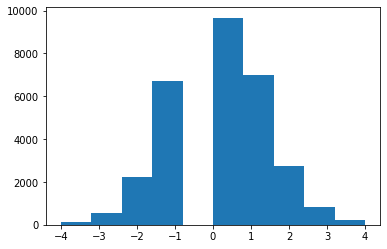

Counter({0: 9670, 1: 7001, -1: 6708, 2: 2753, -2: 2218, 3: 817, -3: 574, 4: 208, -4: 122})


In [70]:
plt.hist(stand_data.train_y)
plt.show()
print(Counter(stand_data.train_y))

In [9]:
rf_grid = RandomForestClassifier()
rf_params = {'n_estimators':[10,35,50,70,90,150],'max_depth':[None,1,3,8,15,25], 
             'min_samples_split':[2,5,10]}
rf_grid_search = GridSearchCV(rf_grid,rf_params)
rf_grid_search.fit(stand_data.train_x, stand_data.train_y)
rf_grid_pred = rf_grid_search.predict(stand_data.test_x)
rf_grid_acc = accuracy_score(stand_data.test_y, rf_grid_pred)
print("Best Fit model acc for grid search: " + str(rf_grid_acc))

/home/brian/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Fit model acc for grid search: 0.3627294493216281


In [14]:
#Best Params: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 90}
#Best Params: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 150}
#Best Fit model acc for grid search: 0.3635275339185954
print("Best Params: " + str(rf_grid_search.best_params_))

Best Params: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 150}


In [83]:
rf_best = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_best.fit(stand_data.train_x, stand_data.train_y)
rf_best_pred = rf_best.predict(stand_data.test_x)
rf_best_acc = accuracy_score(stand_data.test_y, rf_best_pred)
print("Accuracy: " + str(rf_best_acc))

Accuracy: 0.3684490555998936


## Random Forest by Period

In [471]:
periodData = NHL_Period_Data()
periodData.binScores(max_bin=1, min_bin=-1)
periodData.splitByPeriod()
periodData.trainTestSplit(split=0.2, period=1)
periodData.transformPeriodData("MinMaxScaler")

Accuracy: 0.3988439306358382


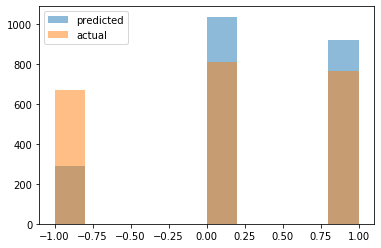

In [474]:
rf_period1 = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_period1.fit(periodData.train_p1_x, periodData.train_p1_y)
rf_p1_pred = rf_period1.predict(periodData.test_p1_x)
rf_p1_acc = accuracy_score(periodData.test_p1_y, rf_p1_pred)
print("Accuracy: " + str(rf_p1_acc))

plt.hist(rf_p1_pred, alpha=0.5, label='predicted')
plt.hist(periodData.test_p1_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

Accuracy: 0.41662961316140507


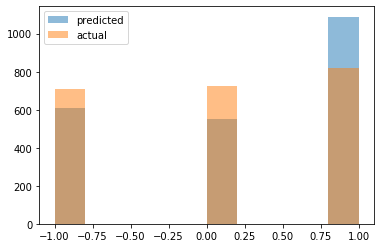

In [475]:
#periodData.trainTestSplit(split=0.2, period=2)
rf_period2 = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_period2.fit(periodData.train_p2_x, periodData.train_p2_y)
rf_p2_pred = rf_period2.predict(periodData.test_p2_x)
rf_p2_acc = accuracy_score(periodData.test_p2_y, rf_p2_pred)

print("Accuracy: " + str(rf_p2_acc))
plt.hist(rf_p2_pred, alpha=0.5, label='predicted')
plt.hist(periodData.test_p2_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

Accuracy: 0.4682080924855491


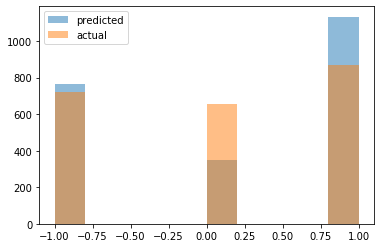

In [476]:
#periodData.trainTestSplit(split=0.2, period=3)
rf_period3 = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_period3.fit(periodData.train_p3_x, periodData.train_p3_y)
rf_p3_pred = rf_period3.predict(periodData.test_p3_x)
rf_p3_acc = accuracy_score(periodData.test_p3_y, rf_p3_pred)

print("Accuracy: " + str(rf_p3_acc))
plt.hist(rf_p3_pred, alpha=0.5, label='predicted')
plt.hist(periodData.test_p3_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

OT samples: 30070
Accuracy: 0.7603626943005182


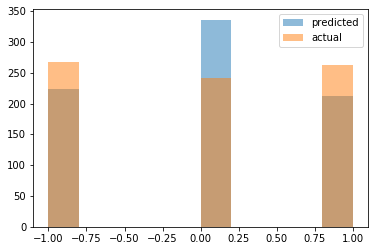

In [477]:
#periodData.trainTestSplit(split=0.2, period=4)
print("OT samples: " + str(len(periodData.train_x)))
rf_periodOT = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=150)
rf_periodOT.fit(periodData.train_p4_x, periodData.train_p4_y)
rf_pOT_pred = rf_periodOT.predict(periodData.test_p4_x)
rf_pOT_acc = accuracy_score(periodData.test_p4_y, rf_pOT_pred)

print("Accuracy: " + str(rf_pOT_acc))
plt.hist(rf_pOT_pred, alpha=0.5, label='predicted')
plt.hist(periodData.test_p4_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

## Boosting classifiers

In [478]:
boostData = NHL_Period_Data()
boostData.binScores(max_bin=1, min_bin=-1)
boostData.splitByPeriod()
boostData.trainTestSplit(split=0.2)
boostData.transformData("MinMaxScaler")
print(boostData.train_x.shape)
print(boostData.train_x[0])

(30070, 19)
[-1.          7.          8.          9.         13.          0.
  2.          8.         11.          2.          3.          1.
  0.          6.         13.          4.          3.         53.57142857
 44.54545455]


Gradient Boost Acc: 0.45411013567438147


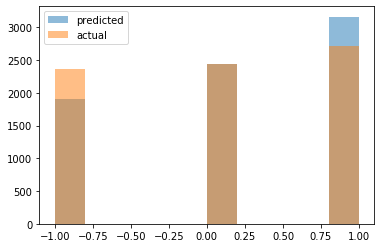

In [479]:
gBoost = GradientBoostingClassifier()
gBoost.fit(boostData.train_x, boostData.train_y)
gb_pred = gBoost.predict(boostData.test_x)
gb_acc = accuracy_score(boostData.test_y, gb_pred)
print("Gradient Boost Acc: " + str(gb_acc))
plt.hist(gb_pred, alpha=0.5, label='predicted')
plt.hist(boostData.test_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

In [480]:
gBoost = GradientBoostingClassifier()
params = {'n_estimators':[50,100,150,200,300],'learning_rate':[0.1,0.3,0.6,1,1.342],
          'max_depth':[1,3,8], 'max_leaf_nodes':[10,50,75,100]}
gb_grid = GridSearchCV(estimator=gBoost, param_grid=params, n_jobs=-1, cv=5)
gb_grid.fit(boostData.train_x, boostData.train_y)
gb_pred = gb_grid.predict(boostData.test_x)
gb_acc = accuracy_score(boostData.test_y, gb_pred)
print("Best Params: " + str(gb_grid.best_params_))
print("Accuracy: " + str(gb_acc))
plt.hist(gb_pred, alpha=0.5, label='predicted')
plt.hist(boostData.test_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

KeyboardInterrupt: 

0 = period initial goal differential <br></br>
1 = blocked shots away<br></br>
2 = blocked shots home<br></br>
3 = faceoff away<br></br>
4 = faceoff home<br></br>
5 = giveaway away<br></br>
6 = giveaway home<br></br>
7 = hit away<br></br>
8 = hit home <br></br>
9 = missed shot away <br></br>
10 = missed shot home<br></br>
11 = penalty away<br></br>
12 = penalty home <br></br>
13 = shot away<br></br>
14 = shot home<br></br>
15 = takeaway away<br></br>
16 = takeaway home<br></br>
17 = Av Shift Length Home <br></br>
18 = Av Shift Length Away <br></br>


In [481]:
select_data = NHL_Period_Data()
select_data.binScores(max_bin=1, min_bin=-1)
select_data.splitByPeriod()
select_data.trainTestSplit(split=0.2,period=i)
#select_data.transformPeriodData(encoder="MinMaxScaler", cols=None)
select_data.transformPeriodData(encoder="MinMaxScaler", cols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

Period 2
Gradient Boost Acc: 0.41040462427745666


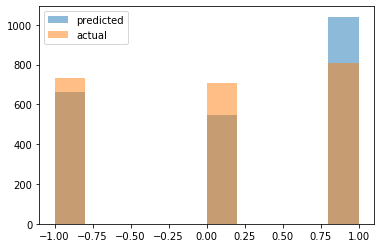

Period 3
Gradient Boost Acc: 0.45798132503334815


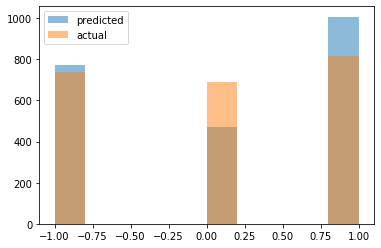

In [482]:
# Gradient Boost Params:
# Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'max_leaf_nodes': 50, 'n_estimators': 200}
# Accuracy: 0.4507847831870178
x_train = {1:"train_p1_x", 2:"train_p2_x", 3:"train_p3_x", 4:"train_p4_x"}
y_train = {1:"train_p1_y", 2:"train_p2_y", 3:"train_p3_y", 4:"train_p4_y"}
x_test = {1:"test_p1_x", 2:"test_p2_x", 3:"test_p3_x", 4:"test_p4_x"}
y_test = {1:"test_p1_y", 2:"test_p2_y", 3:"test_p3_y", 4:"test_p4_y"}
for i in range(2,4):
    print("Period " + str(i))
    gBoost_select_f = GradientBoostingClassifier(learning_rate=.1, max_depth=3, max_leaf_nodes=50,
                                                 n_estimators=200)
    gBoost_select_f.fit(getattr(select_data,x_train[i]), getattr(select_data,y_train[i]))
    gb_sf_pred = gBoost_select_f.predict(getattr(select_data,x_test[i]))
    gb_sf_acc = accuracy_score(getattr(select_data,y_test[i]), gb_sf_pred)
    print("Gradient Boost Acc: " + str(gb_sf_acc))
    plt.hist(gb_sf_pred, alpha=0.5, label='predicted')
    plt.hist(getattr(select_data,y_test[i]), alpha=0.5, label='actual')
    plt.legend(loc='best')
    plt.show()

In [483]:
select_data = NHL_Period_Data()
select_data.binScores(max_bin=1, min_bin=-1)
select_data.splitByPeriod()
select_data.trainTestSplit(split=0.2,period=i)
#select_data.transformPeriodData(encoder="MinMaxScaler", cols=None)
select_data.transformPeriodData(encoder="MinMaxScaler", cols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

Period 1
Gradient Boost Acc: 0.37572254335260113


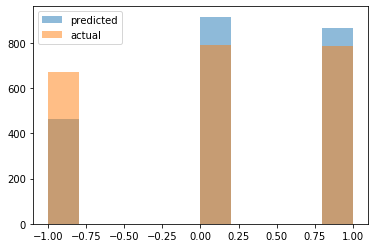

Period 4
Gradient Boost Acc: 0.75


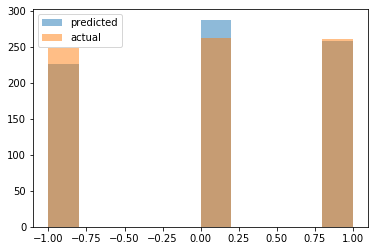

In [484]:
for i in [1,4]:
    print("Period " + str(i))
    gBoost_select_f = GradientBoostingClassifier(learning_rate=.1, max_depth=3, max_leaf_nodes=50,
                                                 n_estimators=200)
    gBoost_select_f.fit(getattr(select_data,x_train[i]), getattr(select_data,y_train[i]))
    gb_sf_pred = gBoost_select_f.predict(getattr(select_data,x_test[i]))
    gb_sf_acc = accuracy_score(getattr(select_data,y_test[i]), gb_sf_pred)
    print("Gradient Boost Acc: " + str(gb_sf_acc))
    plt.hist(gb_sf_pred, alpha=0.5, label='predicted')
    plt.hist(getattr(select_data,y_test[i]), alpha=0.5, label='actual')
    plt.legend(loc='best')
    plt.show()

Gradient Boost Acc: 0.7110103626943005


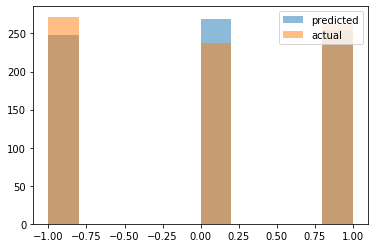

In [485]:
select_data = NHL_Period_Data()
select_data.binScores(max_bin=1, min_bin=-1)
select_data.splitByPeriod()
p = 4
select_data.trainTestSplit(split=0.2,period=p)
#select_data.transformPeriodData(encoder="MinMaxScaler", cols=None)
select_data.transformPeriodData(encoder="MinMaxScaler", cols=[3,4,7,8,9,10,11,12,13,14,15,16])

av_acc = 0
for i in range(10):
    gBoost_select_f = GradientBoostingClassifier(learning_rate=.1, max_depth=3, max_leaf_nodes=50,
                                             n_estimators=200)
    gBoost_select_f.fit(getattr(select_data,x_train[p]), getattr(select_data,y_train[p]))
    gb_sf_pred = gBoost_select_f.predict(getattr(select_data,x_test[p]))
    av_acc += accuracy_score(getattr(select_data,y_test[p]), gb_sf_pred)
gb_sf_acc = av_acc/10
print("Gradient Boost Acc: " + str(gb_sf_acc))
plt.hist(gb_sf_pred, alpha=0.5, label='predicted')
plt.hist(getattr(select_data,y_test[p]), alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()

Period: 1
Shift Data Acc: 0.4126278345931525


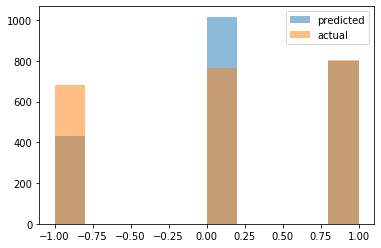

Period: 2
Shift Data Acc: 0.4286349488661627


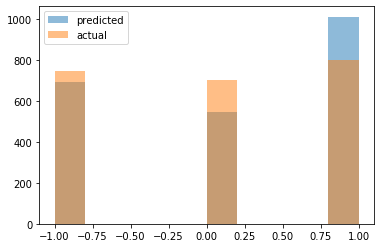

Period: 3
Shift Data Acc: 0.46465095598043576


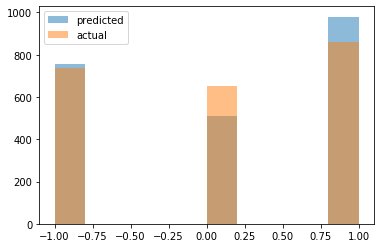

Period: 4
Shift Data Acc: 0.7772020725388601


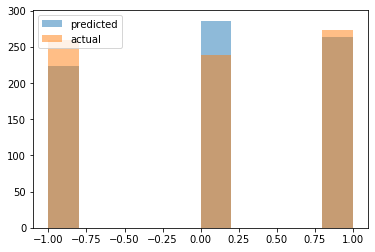

In [488]:
shiftData = NHL_Period_Data()
shiftData.binScores(max_bin=1, min_bin=-1)
shiftData.splitByPeriod()
shiftData.trainTestSplit(split=0.2)
shiftData.transformPeriodData(encoder="MinMaxScaler", cols=None)

for i in range(1,5):
    gBoost_shift = GradientBoostingClassifier(learning_rate=.1, max_depth=3, max_leaf_nodes=50,
                                             n_estimators=200)
    gBoost_shift.fit(getattr(shiftData,x_train[i]), getattr(shiftData,y_train[i]))
    gb_shift_pred = gBoost_shift.predict(getattr(shiftData,x_test[i]))
    shift_acc = accuracy_score(getattr(shiftData,y_test[i]), gb_shift_pred)
    print("Period: " + str(i))
    print("Shift Data Acc: " + str(shift_acc))
    plt.hist(gb_shift_pred, alpha=0.5, label='predicted')
    plt.hist(getattr(shiftData,y_test[i]), alpha=0.5, label='actual')
    plt.legend(loc='best')
    plt.show()

In [515]:
shiftcolData = NHL_Period_Data()
shiftcolData.binScores(max_bin=1, min_bin=-1)
shiftcolData.splitByPeriod()
shiftcolData.trainTestSplit(split=0.2)
shiftcolData.transformPeriodData(encoder="MinMaxScaler")

Finding Features for Period 1
Features: [0]
Column Accuracy: 0.3570475767007559


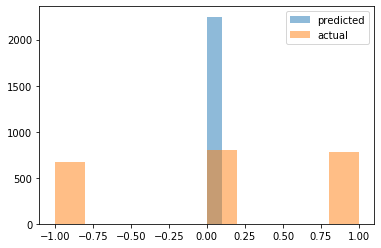

Features: [1, 2]
Column Accuracy: 0.339261894175189


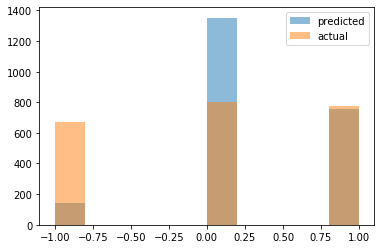

Features: [3, 4]
Column Accuracy: 0.3606047132058693


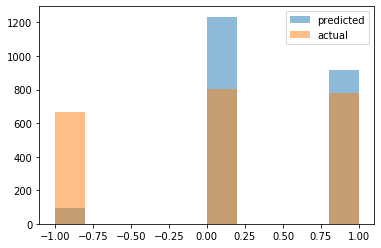

Features: [5, 6]
Column Accuracy: 0.3539350822587817


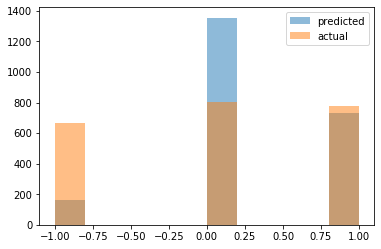

Features: [7, 8]
Column Accuracy: 0.36327256558470433


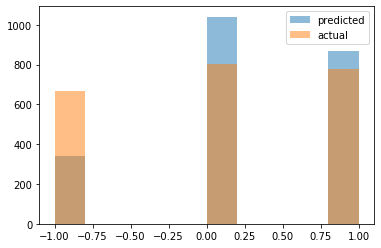

Features: [9, 10]
Column Accuracy: 0.3423743886171632


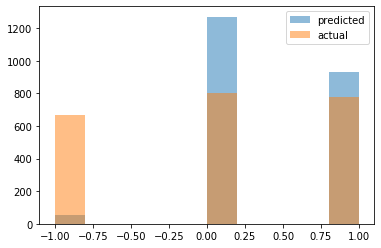

Features: [11, 12]
Column Accuracy: 0.38861716318363715


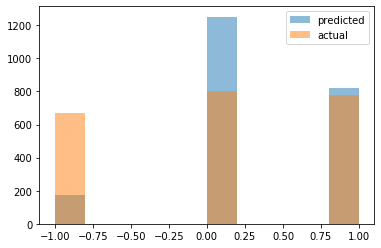

Features: [13, 14]
Column Accuracy: 0.3588261449533126


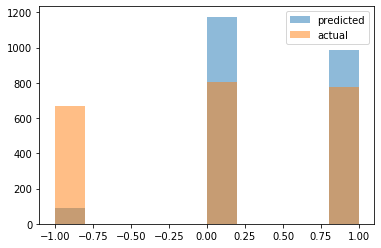

Features: [15, 16]
Column Accuracy: 0.3464650955980436


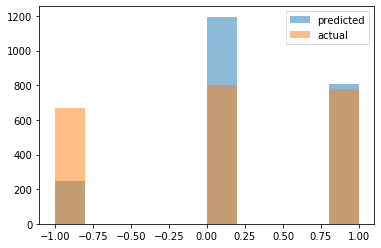

Features: [17, 18]
Column Accuracy: 0.3872832369942196


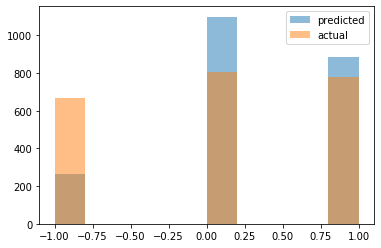

~~~ Choosing Max Cols: [11, 12]
~~~ Max Accuracy: 0.38861716318363715
Remaining Columns: [[0], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [13, 14], [15, 16], [17, 18]]
Features: [11, 12, 0]
Column Accuracy: 0.38861716318363715


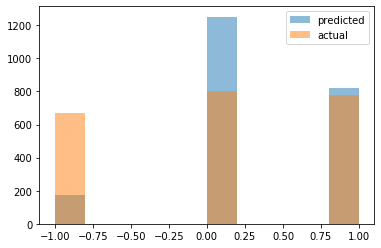

Features: [11, 12, 1, 2]
Column Accuracy: 0.3703868385949311


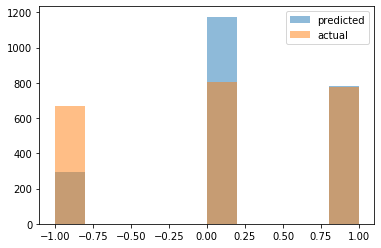

Features: [11, 12, 3, 4]
Column Accuracy: 0.3815028901734104


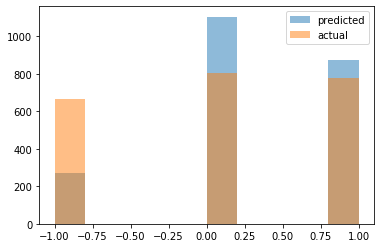

Features: [11, 12, 5, 6]
Column Accuracy: 0.3895064473099155


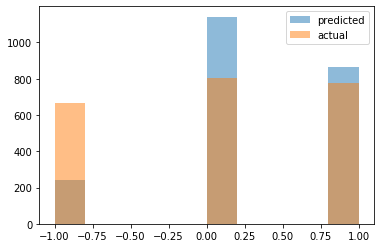

Features: [11, 12, 7, 8]
Column Accuracy: 0.3815028901734104


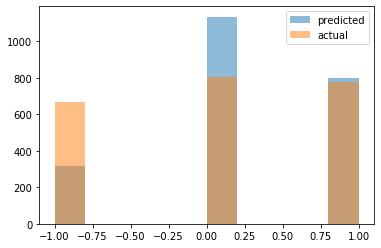

Features: [11, 12, 9, 10]
Column Accuracy: 0.3828368163628279


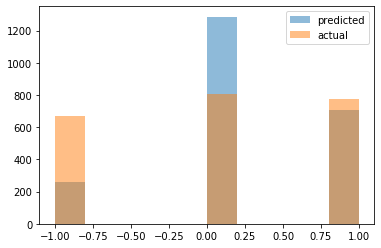

Features: [11, 12, 13, 14]
Column Accuracy: 0.36549577590040017


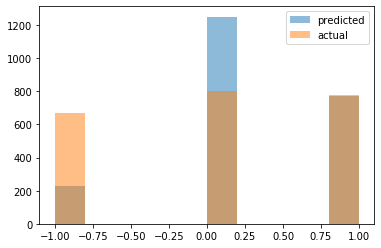

Features: [11, 12, 15, 16]
Column Accuracy: 0.38594931080480216


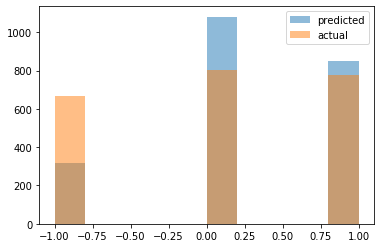

Features: [11, 12, 17, 18]
Column Accuracy: 0.4052467763450423


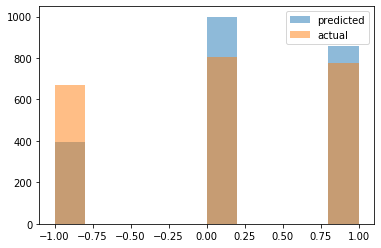

~~~ Choosing Max Cols: [17, 18]
~~~ Max Accuracy: 0.4052467763450423
Remaining Columns: [[0], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [13, 14], [15, 16]]
Features: [11, 12, 17, 18, 0]
Column Accuracy: 0.4052467763450422


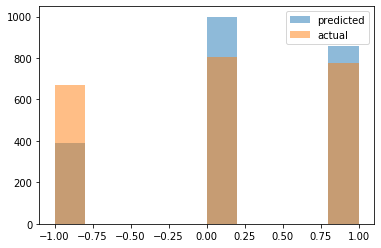

Features: [11, 12, 17, 18, 1, 2]
Column Accuracy: 0.41262783459315255


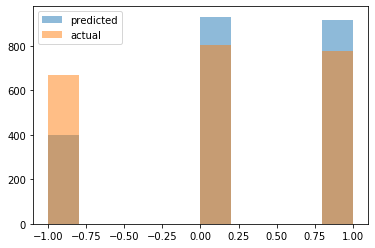

Features: [11, 12, 17, 18, 3, 4]
Column Accuracy: 0.4142285460204535


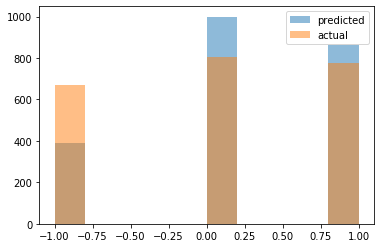

Features: [11, 12, 17, 18, 5, 6]
Column Accuracy: 0.40720320142285465


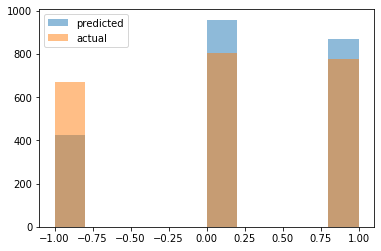

Features: [11, 12, 17, 18, 7, 8]
Column Accuracy: 0.3969764339706536


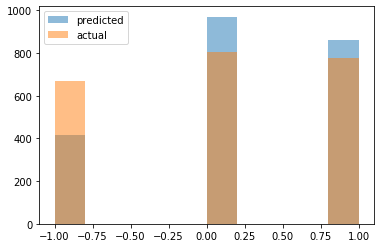

Features: [11, 12, 17, 18, 9, 10]
Column Accuracy: 0.3996442863494886


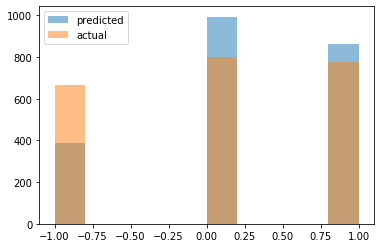

Features: [11, 12, 17, 18, 13, 14]
Column Accuracy: 0.3927967985771454


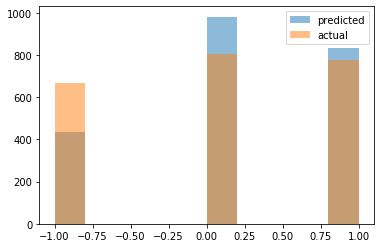

Features: [11, 12, 17, 18, 15, 16]
Column Accuracy: 0.4081814139617608


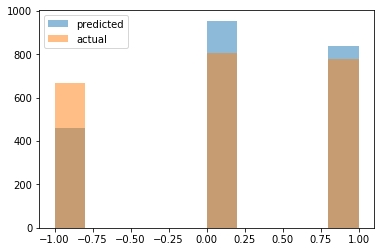

~~~ Choosing Max Cols: [3, 4]
~~~ Max Accuracy: 0.4142285460204535
Remaining Columns: [[0], [1, 2], [5, 6], [7, 8], [9, 10], [13, 14], [15, 16]]
Features: [11, 12, 17, 18, 3, 4, 0]
Column Accuracy: 0.4142285460204535


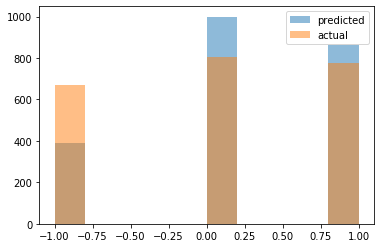

Features: [11, 12, 17, 18, 3, 4, 1, 2]
Column Accuracy: 0.4104046242774566


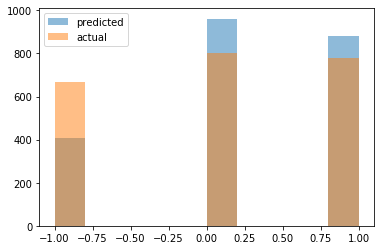

Features: [11, 12, 17, 18, 3, 4, 5, 6]
Column Accuracy: 0.41618497109826597


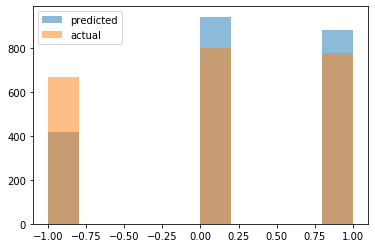

Features: [11, 12, 17, 18, 3, 4, 7, 8]
Column Accuracy: 0.41289461983103604


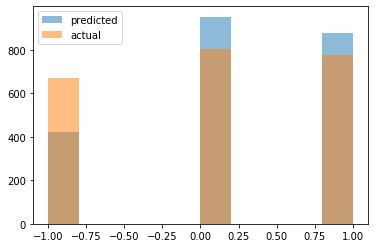

Features: [11, 12, 17, 18, 3, 4, 9, 10]
Column Accuracy: 0.4170742552245443


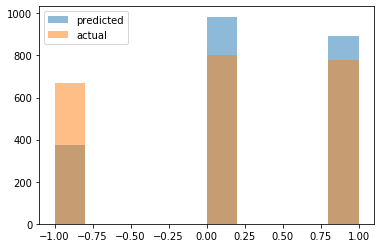

Features: [11, 12, 17, 18, 3, 4, 13, 14]
Column Accuracy: 0.4043574922187639


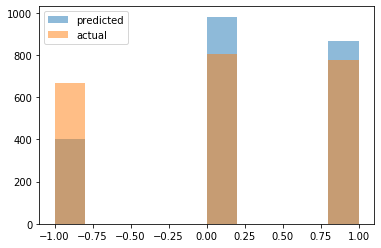

Features: [11, 12, 17, 18, 3, 4, 15, 16]
Column Accuracy: 0.4064028457092041


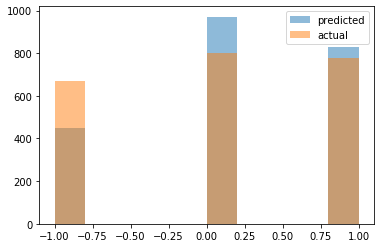

~~~ Choosing Max Cols: [9, 10]
~~~ Max Accuracy: 0.4170742552245443
Remaining Columns: [[0], [1, 2], [5, 6], [7, 8], [13, 14], [15, 16]]
Features: [11, 12, 17, 18, 3, 4, 9, 10, 0]
Column Accuracy: 0.4173410404624277


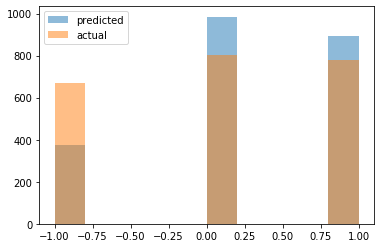

Features: [11, 12, 17, 18, 3, 4, 9, 10, 1, 2]
Column Accuracy: 0.4009782125389062


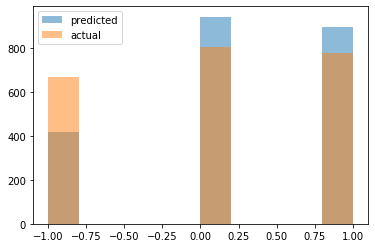

Features: [11, 12, 17, 18, 3, 4, 9, 10, 5, 6]
Column Accuracy: 0.40444642063139175


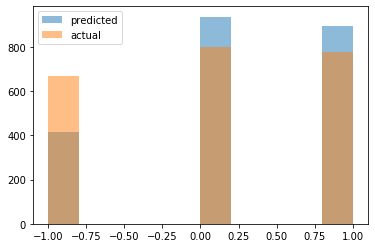

Features: [11, 12, 17, 18, 3, 4, 9, 10, 7, 8]
Column Accuracy: 0.42214317474433083


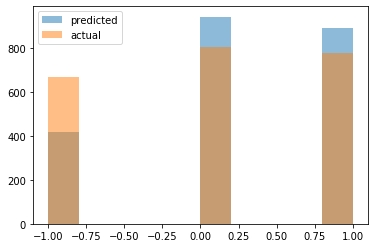

Features: [11, 12, 17, 18, 3, 4, 9, 10, 13, 14]
Column Accuracy: 0.40746998666073814


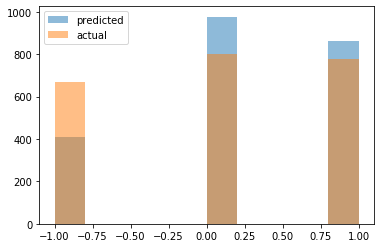

Features: [11, 12, 17, 18, 3, 4, 9, 10, 15, 16]
Column Accuracy: 0.4046242774566474


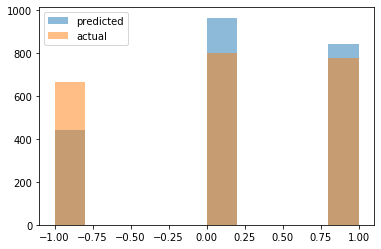

~~~ Choosing Max Cols: [7, 8]
~~~ Max Accuracy: 0.42214317474433083
Remaining Columns: [[0], [1, 2], [5, 6], [13, 14], [15, 16]]
Features: [11, 12, 17, 18, 3, 4, 9, 10, 7, 8, 0]
Column Accuracy: 0.42187638950644735


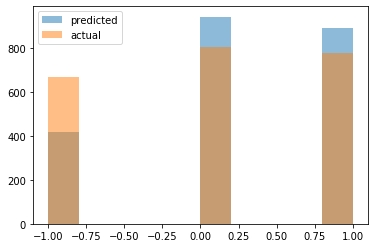

Features: [11, 12, 17, 18, 3, 4, 9, 10, 7, 8, 1, 2]
Column Accuracy: 0.4193863939528679


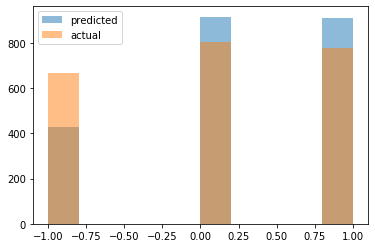

Features: [11, 12, 17, 18, 3, 4, 9, 10, 7, 8, 5, 6]
Column Accuracy: 0.416629613161405


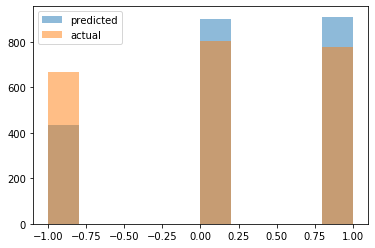

Features: [11, 12, 17, 18, 3, 4, 9, 10, 7, 8, 13, 14]
Column Accuracy: 0.411827478879502


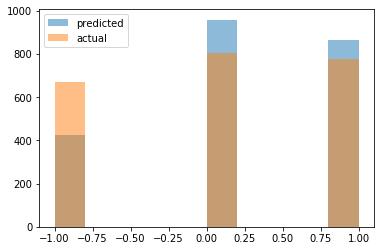

Features: [11, 12, 17, 18, 3, 4, 9, 10, 7, 8, 15, 16]
Column Accuracy: 0.40746998666073814


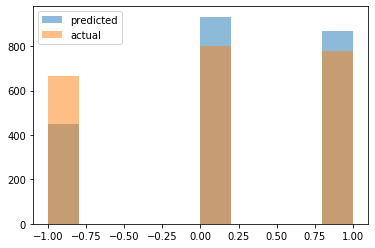

Adding [0] showed no improvement, stopping...
Best Columns found: [11, 12, 17, 18, 3, 4, 9, 10, 7, 8]
For Period 1 Best Columns found: [11, 12, 17, 18, 3, 4, 9, 10, 7, 8] With accuracy: 0.42214317474433083
Finding Features for Period 2
Features: [0]
Column Accuracy: 0.3272565584704313


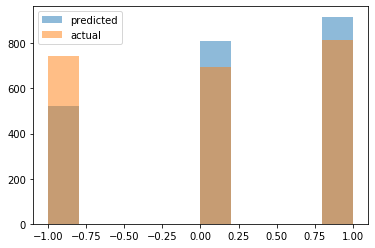

Features: [1, 2]
Column Accuracy: 0.3601600711427301


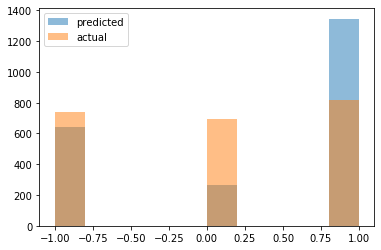

Features: [3, 4]
Column Accuracy: 0.3588261449533126


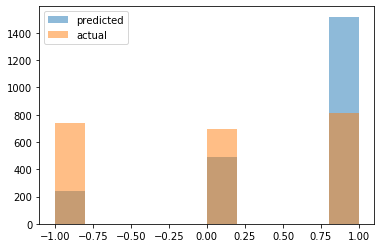

Features: [5, 6]
Column Accuracy: 0.36860827034237437


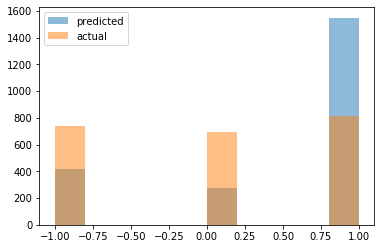

Features: [7, 8]
Column Accuracy: 0.36638506002667853


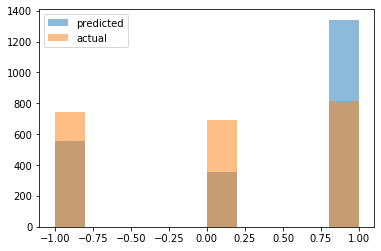

Features: [9, 10]
Column Accuracy: 0.3454868830591374


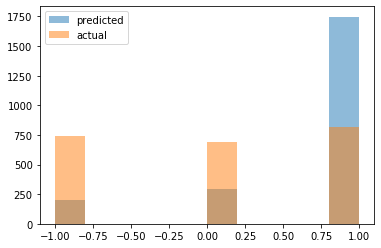

Features: [11, 12]
Column Accuracy: 0.35126722987994663


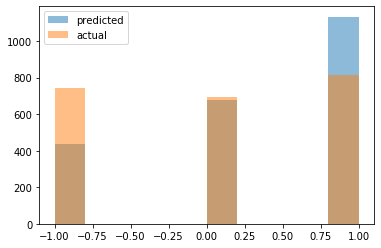

Features: [13, 14]
Column Accuracy: 0.3374833259226323


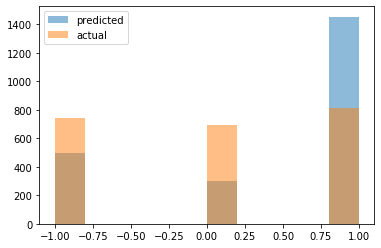

Features: [15, 16]
Column Accuracy: 0.3454868830591374


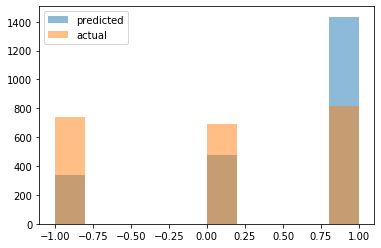

Features: [17, 18]
Column Accuracy: 0.3843485993775011


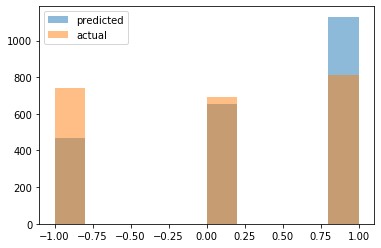

~~~ Choosing Max Cols: [17, 18]
~~~ Max Accuracy: 0.3843485993775011
Remaining Columns: [[0], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16]]
Features: [17, 18, 0]
Column Accuracy: 0.37305469097376615


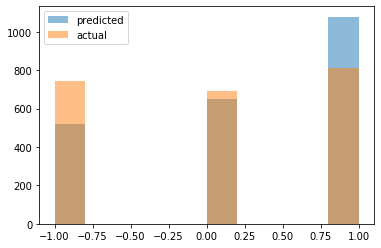

Features: [17, 18, 1, 2]
Column Accuracy: 0.3778568252556692


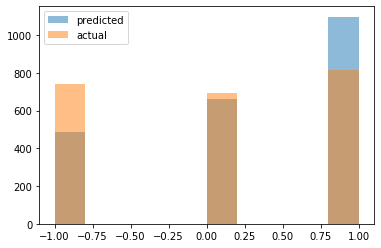

Features: [17, 18, 3, 4]
Column Accuracy: 0.37180969319697643


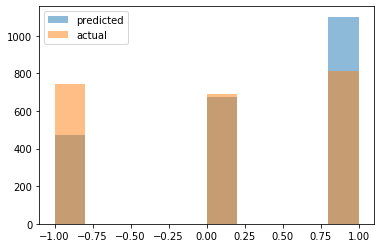

Features: [17, 18, 5, 6]
Column Accuracy: 0.38594931080480216


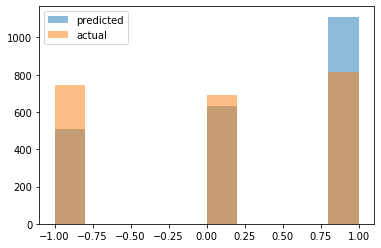

Features: [17, 18, 7, 8]
Column Accuracy: 0.3828368163628279


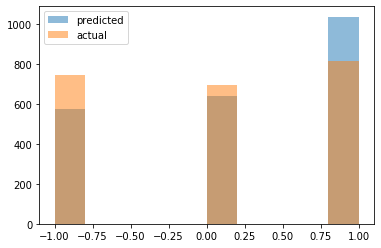

Features: [17, 18, 9, 10]
Column Accuracy: 0.37652289906625164


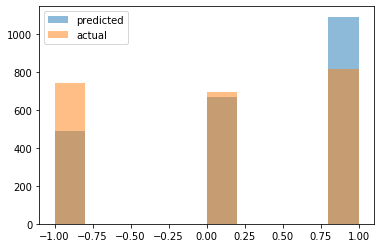

Features: [17, 18, 11, 12]
Column Accuracy: 0.39839928857269896


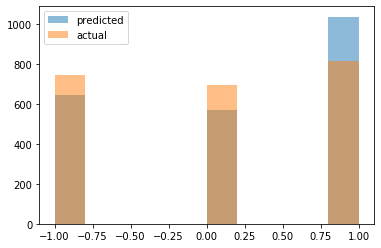

Features: [17, 18, 13, 14]
Column Accuracy: 0.37261004891062693


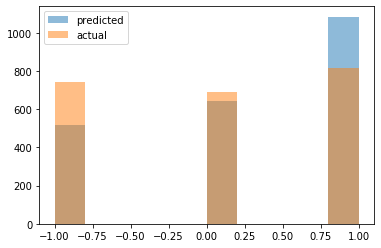

Features: [17, 18, 15, 16]
Column Accuracy: 0.3838150289017341


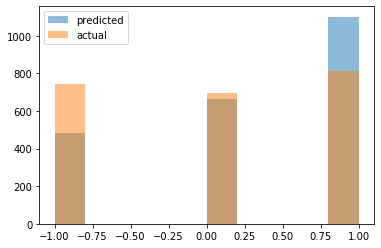

~~~ Choosing Max Cols: [11, 12]
~~~ Max Accuracy: 0.39839928857269896
Remaining Columns: [[0], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [13, 14], [15, 16]]
Features: [17, 18, 11, 12, 0]
Column Accuracy: 0.3943975100044464


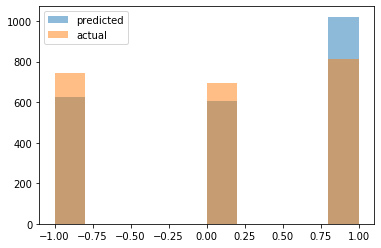

Features: [17, 18, 11, 12, 1, 2]
Column Accuracy: 0.39084037349933304


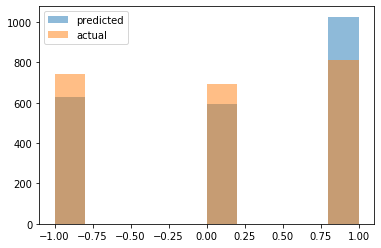

Features: [17, 18, 11, 12, 3, 4]
Column Accuracy: 0.39350822587816814


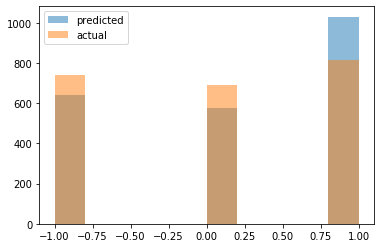

Features: [17, 18, 11, 12, 5, 6]
Column Accuracy: 0.3966207203201423


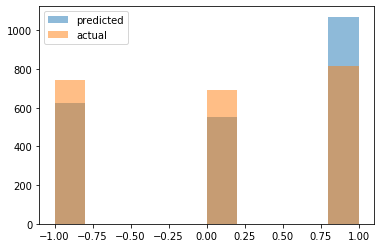

Features: [17, 18, 11, 12, 7, 8]
Column Accuracy: 0.38497109826589593


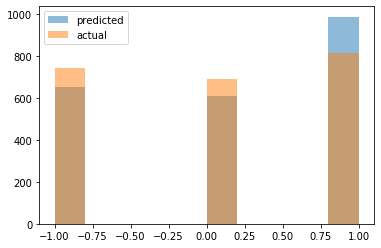

Features: [17, 18, 11, 12, 9, 10]
Column Accuracy: 0.39413072476656297


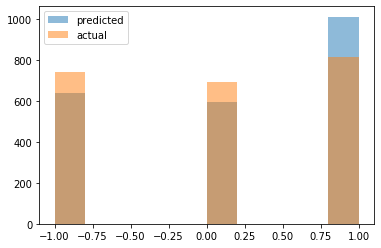

Features: [17, 18, 11, 12, 13, 14]
Column Accuracy: 0.3792796798577145


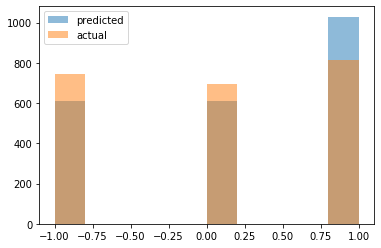

Features: [17, 18, 11, 12, 15, 16]
Column Accuracy: 0.3988439306358382


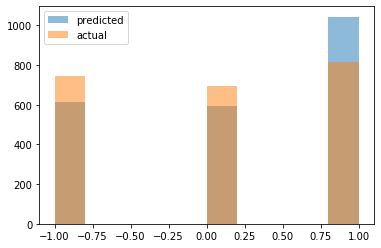

~~~ Choosing Max Cols: [15, 16]
~~~ Max Accuracy: 0.3988439306358382
Remaining Columns: [[0], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [13, 14]]
Features: [17, 18, 11, 12, 15, 16, 0]
Column Accuracy: 0.39617607825700313


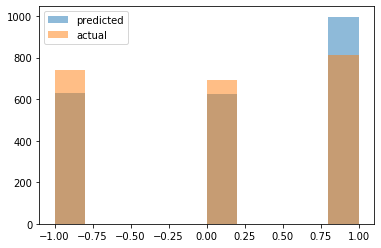

Features: [17, 18, 11, 12, 15, 16, 1, 2]
Column Accuracy: 0.4012449977767897


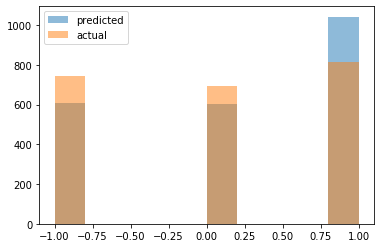

Features: [17, 18, 11, 12, 15, 16, 3, 4]
Column Accuracy: 0.4038239217429969


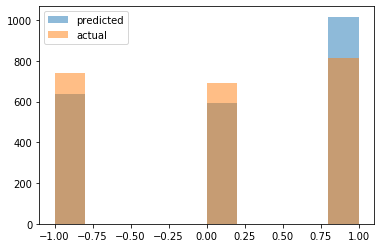

Features: [17, 18, 11, 12, 15, 16, 5, 6]
Column Accuracy: 0.38008003557136505


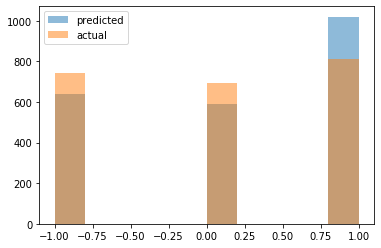

Features: [17, 18, 11, 12, 15, 16, 7, 8]
Column Accuracy: 0.39288572698977325


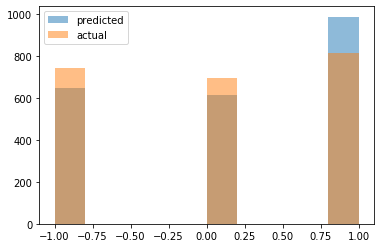

Features: [17, 18, 11, 12, 15, 16, 9, 10]
Column Accuracy: 0.3932414406402846


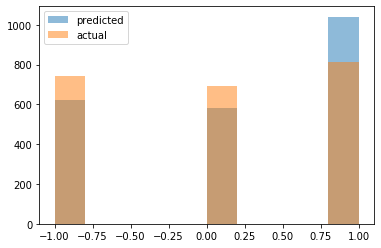

Features: [17, 18, 11, 12, 15, 16, 13, 14]
Column Accuracy: 0.3822143174744331


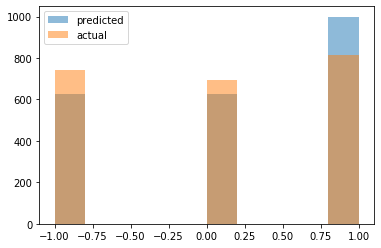

~~~ Choosing Max Cols: [3, 4]
~~~ Max Accuracy: 0.4038239217429969
Remaining Columns: [[0], [1, 2], [5, 6], [7, 8], [9, 10], [13, 14]]
Features: [17, 18, 11, 12, 15, 16, 3, 4, 0]
Column Accuracy: 0.40151178301467316


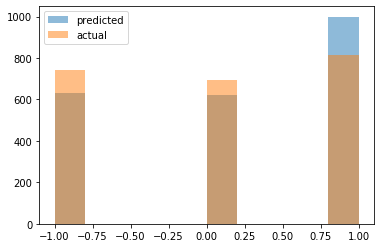

Features: [17, 18, 11, 12, 15, 16, 3, 4, 1, 2]
Column Accuracy: 0.4007114273010227


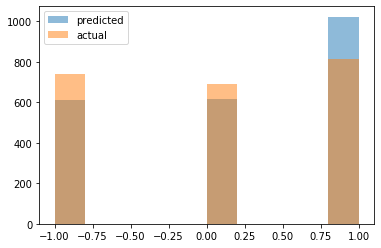

Features: [17, 18, 11, 12, 15, 16, 3, 4, 5, 6]
Column Accuracy: 0.3942196531791907


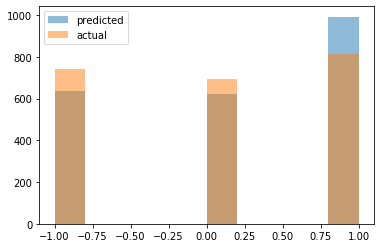

Features: [17, 18, 11, 12, 15, 16, 3, 4, 7, 8]
Column Accuracy: 0.3931525122276568


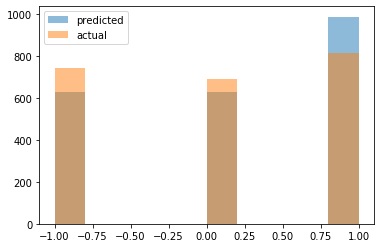

Features: [17, 18, 11, 12, 15, 16, 3, 4, 9, 10]
Column Accuracy: 0.3976878612716763


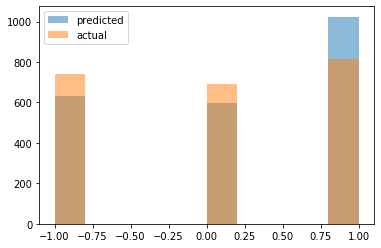

Features: [17, 18, 11, 12, 15, 16, 3, 4, 13, 14]
Column Accuracy: 0.39288572698977325


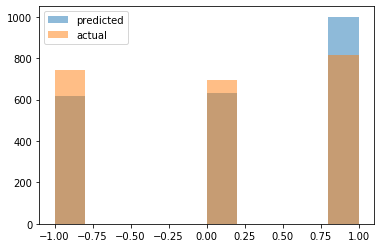

Adding [0] showed no improvement, stopping...
Best Columns found: [17, 18, 11, 12, 15, 16, 3, 4]
For Period 2 Best Columns found: [17, 18, 11, 12, 15, 16, 3, 4] With accuracy: 0.4038239217429969
Finding Features for Period 3
Features: [0]
Column Accuracy: 0.4055135615829258


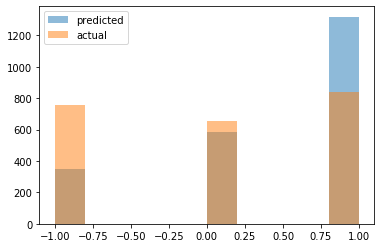

Features: [1, 2]
Column Accuracy: 0.39928857269897733


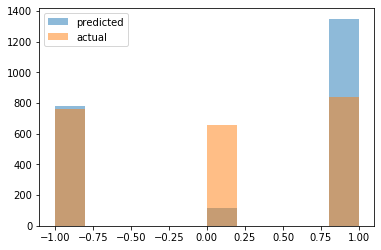

Features: [3, 4]
Column Accuracy: 0.37394397510004446


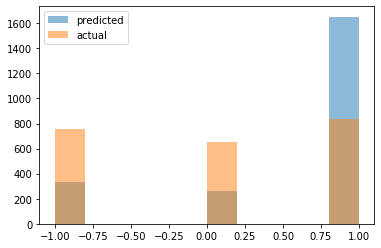

Features: [5, 6]
Column Accuracy: 0.3778568252556692


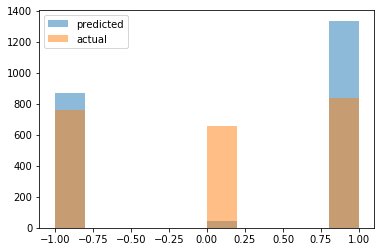

Features: [7, 8]
Column Accuracy: 0.36327256558470433


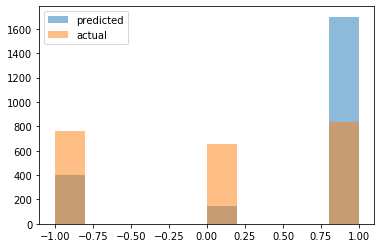

Features: [9, 10]
Column Accuracy: 0.36238328145842597


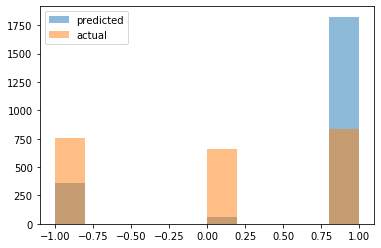

Features: [11, 12]
Column Accuracy: 0.3943975100044464


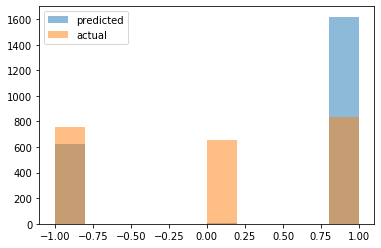

Features: [13, 14]
Column Accuracy: 0.3748332592263228


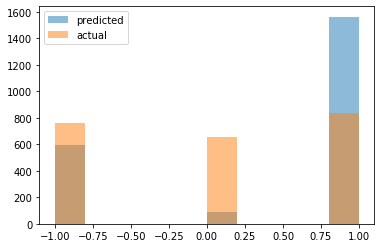

Features: [15, 16]
Column Accuracy: 0.37083148065807026


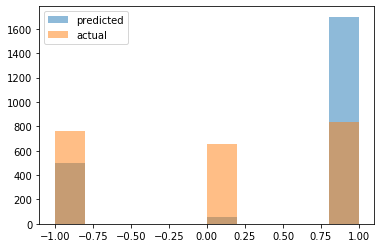

Features: [17, 18]
Column Accuracy: 0.4095153401511783


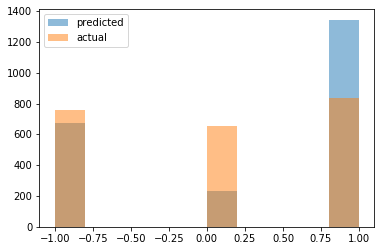

~~~ Choosing Max Cols: [17, 18]
~~~ Max Accuracy: 0.4095153401511783
Remaining Columns: [[0], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16]]
Features: [17, 18, 0]
Column Accuracy: 0.44152956869719884


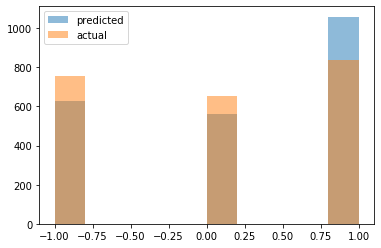

Features: [17, 18, 1, 2]
Column Accuracy: 0.4210760337927968


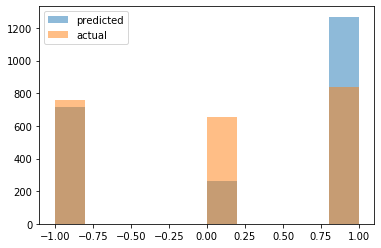

Features: [17, 18, 3, 4]
Column Accuracy: 0.40995998221431745


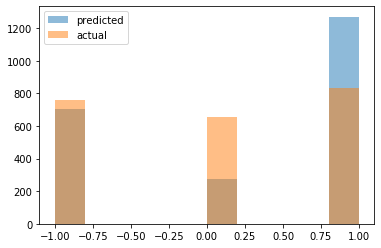

Features: [17, 18, 5, 6]
Column Accuracy: 0.4073810582481102


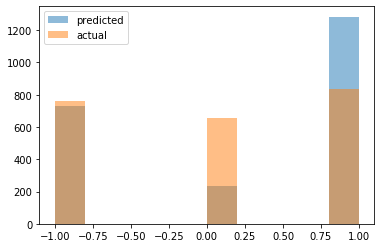

Features: [17, 18, 7, 8]
Column Accuracy: 0.40240106714095153


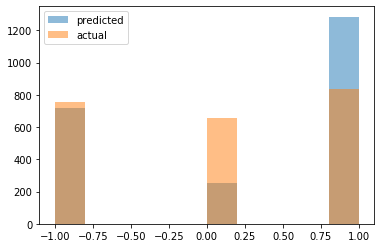

Features: [17, 18, 9, 10]
Column Accuracy: 0.40658070253445977


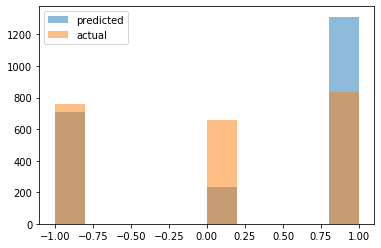

Features: [17, 18, 11, 12]
Column Accuracy: 0.425255669186305


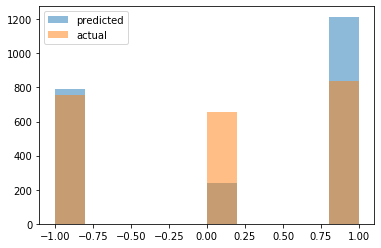

Features: [17, 18, 13, 14]
Column Accuracy: 0.4108492663405959


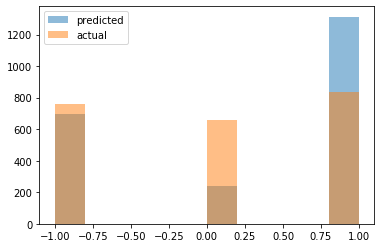

Features: [17, 18, 15, 16]
Column Accuracy: 0.41147176522899065


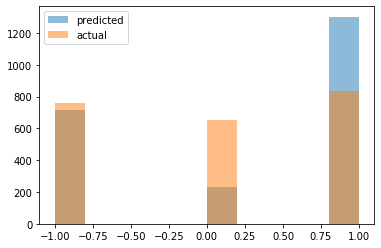

~~~ Choosing Max Cols: [0]
~~~ Max Accuracy: 0.44152956869719884
Remaining Columns: [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16]]
Features: [17, 18, 0, 1, 2]
Column Accuracy: 0.45317919075144514


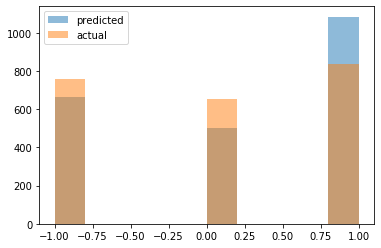

Features: [17, 18, 0, 3, 4]
Column Accuracy: 0.4498888394842152


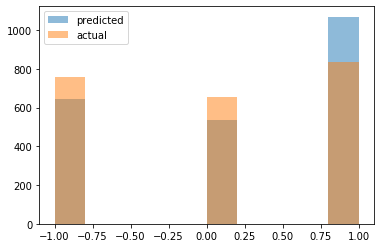

Features: [17, 18, 0, 5, 6]
Column Accuracy: 0.43983992885726986


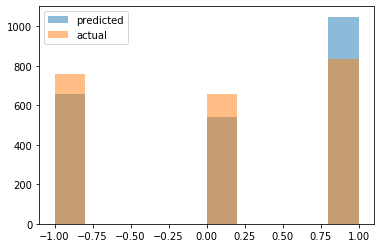

Features: [17, 18, 0, 7, 8]
Column Accuracy: 0.43708314806580695


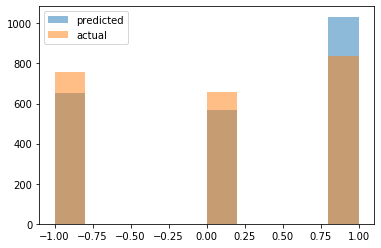

Features: [17, 18, 0, 9, 10]
Column Accuracy: 0.43646064917741223


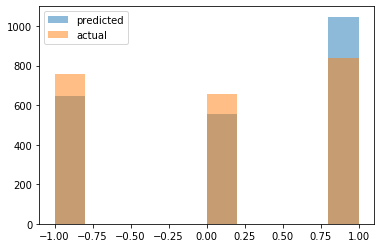

Features: [17, 18, 0, 11, 12]
Column Accuracy: 0.4637616718541574


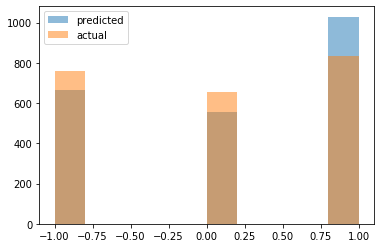

Features: [17, 18, 0, 13, 14]
Column Accuracy: 0.4339706536238328


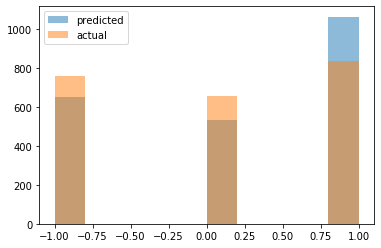

Features: [17, 18, 0, 15, 16]
Column Accuracy: 0.43886171631836374


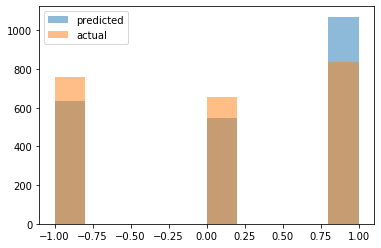

~~~ Choosing Max Cols: [11, 12]
~~~ Max Accuracy: 0.4637616718541574
Remaining Columns: [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [13, 14], [15, 16]]
Features: [17, 18, 0, 11, 12, 1, 2]
Column Accuracy: 0.46998666073810574


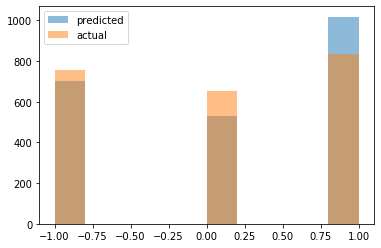

Features: [17, 18, 0, 11, 12, 3, 4]
Column Accuracy: 0.4578034682080926


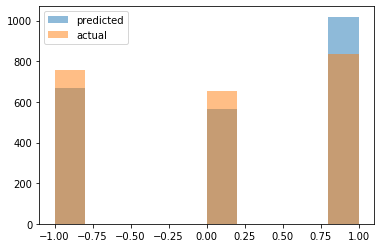

Features: [17, 18, 0, 11, 12, 5, 6]
Column Accuracy: 0.4609159626500666


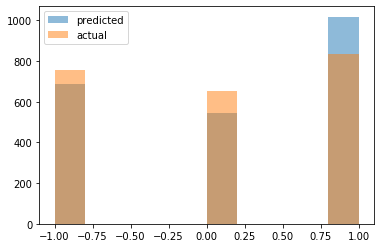

Features: [17, 18, 0, 11, 12, 7, 8]
Column Accuracy: 0.46216096042685634


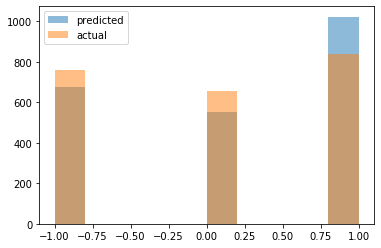

Features: [17, 18, 0, 11, 12, 9, 10]
Column Accuracy: 0.4497999110715873


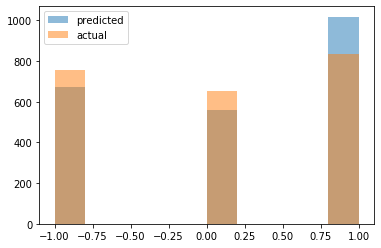

Features: [17, 18, 0, 11, 12, 13, 14]
Column Accuracy: 0.45282347710093374


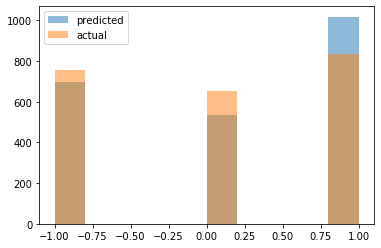

Features: [17, 18, 0, 11, 12, 15, 16]
Column Accuracy: 0.45789239662072034


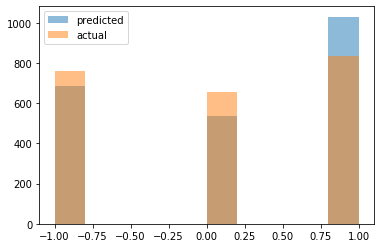

~~~ Choosing Max Cols: [1, 2]
~~~ Max Accuracy: 0.46998666073810574
Remaining Columns: [[3, 4], [5, 6], [7, 8], [9, 10], [13, 14], [15, 16]]
Features: [17, 18, 0, 11, 12, 1, 2, 3, 4]
Column Accuracy: 0.47567807914628724


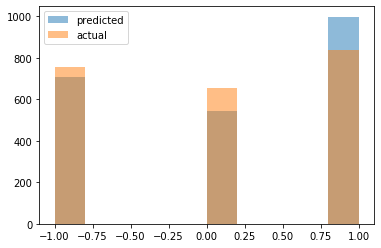

Features: [17, 18, 0, 11, 12, 1, 2, 5, 6]
Column Accuracy: 0.46100489106269454


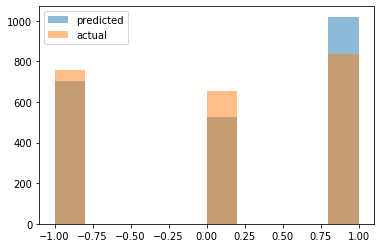

Features: [17, 18, 0, 11, 12, 1, 2, 7, 8]
Column Accuracy: 0.4706091596265007


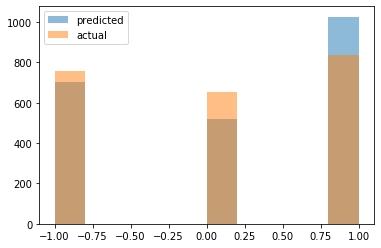

Features: [17, 18, 0, 11, 12, 1, 2, 9, 10]
Column Accuracy: 0.45975989328590483


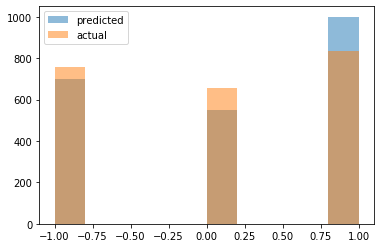

Features: [17, 18, 0, 11, 12, 1, 2, 13, 14]
Column Accuracy: 0.46580702534459756


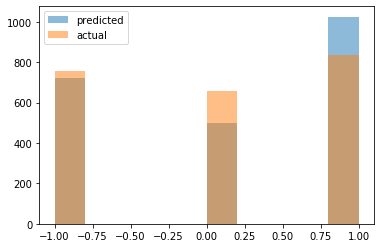

Features: [17, 18, 0, 11, 12, 1, 2, 15, 16]
Column Accuracy: 0.4713205869275233


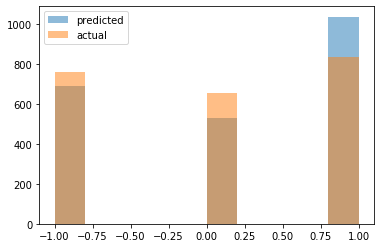

~~~ Choosing Max Cols: [3, 4]
~~~ Max Accuracy: 0.47567807914628724
Remaining Columns: [[5, 6], [7, 8], [9, 10], [13, 14], [15, 16]]
Features: [17, 18, 0, 11, 12, 1, 2, 3, 4, 5, 6]
Column Accuracy: 0.4781680746998666


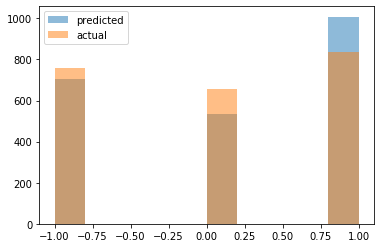

Features: [17, 18, 0, 11, 12, 1, 2, 3, 4, 7, 8]
Column Accuracy: 0.47541129390840375


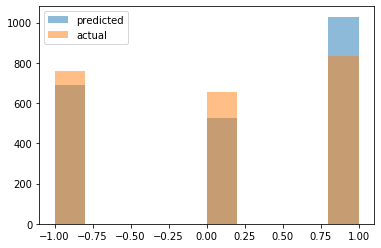

Features: [17, 18, 0, 11, 12, 1, 2, 3, 4, 9, 10]
Column Accuracy: 0.4802134281903069


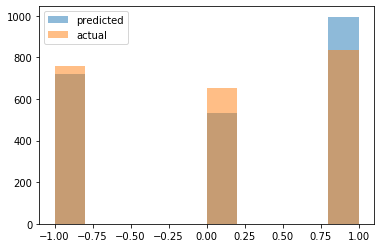

Features: [17, 18, 0, 11, 12, 1, 2, 3, 4, 13, 14]
Column Accuracy: 0.4771009337483326


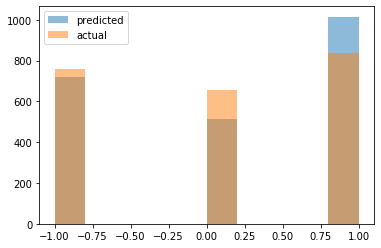

Features: [17, 18, 0, 11, 12, 1, 2, 3, 4, 15, 16]
Column Accuracy: 0.4737216540684749


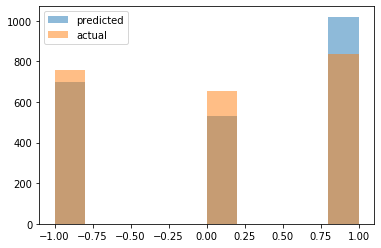

~~~ Choosing Max Cols: [9, 10]
~~~ Max Accuracy: 0.4802134281903069
Remaining Columns: [[5, 6], [7, 8], [13, 14], [15, 16]]
Features: [17, 18, 0, 11, 12, 1, 2, 3, 4, 9, 10, 5, 6]
Column Accuracy: 0.4743441529568697


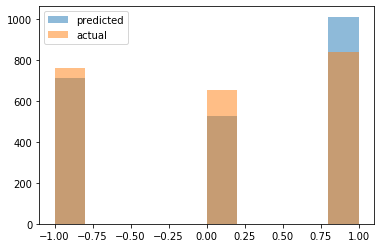

Features: [17, 18, 0, 11, 12, 1, 2, 3, 4, 9, 10, 7, 8]
Column Accuracy: 0.47149844375277905


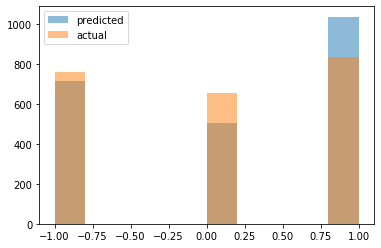

Features: [17, 18, 0, 11, 12, 1, 2, 3, 4, 9, 10, 13, 14]
Column Accuracy: 0.47354379724321916


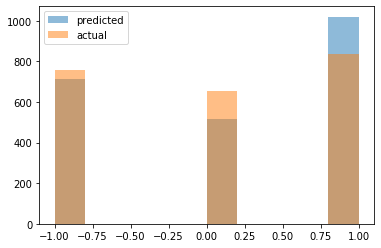

Features: [17, 18, 0, 11, 12, 1, 2, 3, 4, 9, 10, 15, 16]
Column Accuracy: 0.47781236104935526


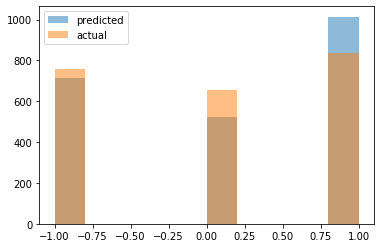

Adding [15, 16] showed no improvement, stopping...
Best Columns found: [17, 18, 0, 11, 12, 1, 2, 3, 4, 9, 10]
For Period 3 Best Columns found: [17, 18, 0, 11, 12, 1, 2, 3, 4, 9, 10] With accuracy: 0.4802134281903069
Finding Features for Period 4
Features: [0]
Column Accuracy: 0.3549222797927461


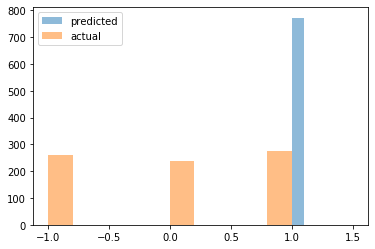

Features: [1, 2]
Column Accuracy: 0.4857512953367876


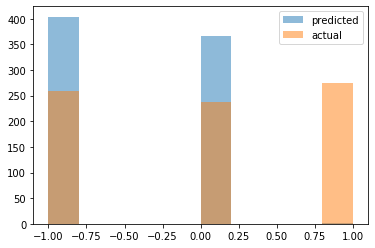

Features: [3, 4]
Column Accuracy: 0.5194300518134715


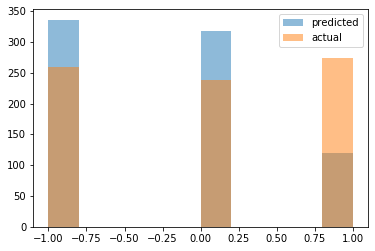

Features: [5, 6]
Column Accuracy: 0.49222797927461137


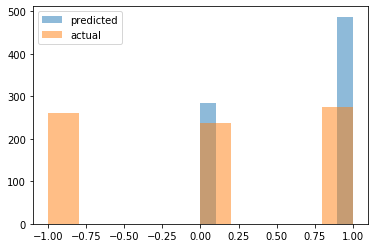

Features: [7, 8]
Column Accuracy: 0.5103626943005182


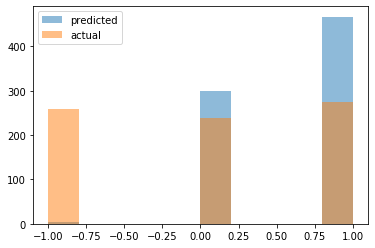

Features: [9, 10]
Column Accuracy: 0.44559585492227977


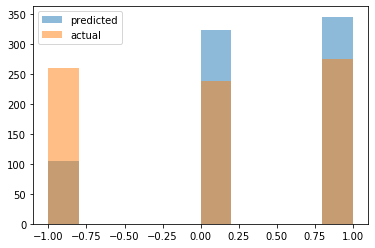

Features: [11, 12]
Column Accuracy: 0.41321243523316065


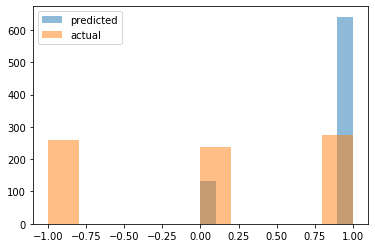

Features: [13, 14]
Column Accuracy: 0.5064766839378239


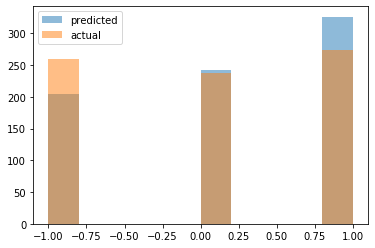

Features: [15, 16]
Column Accuracy: 0.48056994818652854


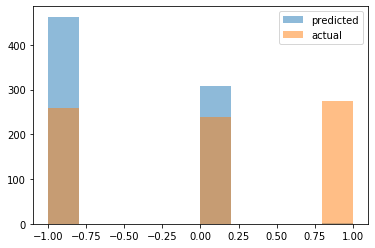

Features: [17, 18]
Column Accuracy: 0.5803108808290155


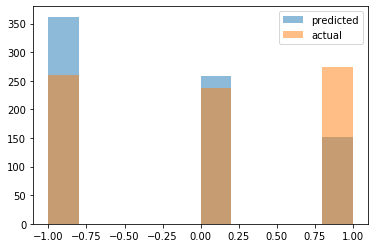

~~~ Choosing Max Cols: [17, 18]
~~~ Max Accuracy: 0.5803108808290155
Remaining Columns: [[0], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16]]
Features: [17, 18, 0]
Column Accuracy: 0.5803108808290155


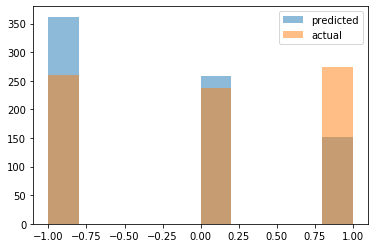

Features: [17, 18, 1, 2]
Column Accuracy: 0.5658031088082902


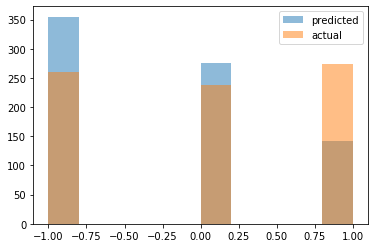

Features: [17, 18, 3, 4]
Column Accuracy: 0.5854922279792746


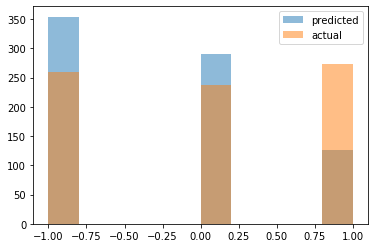

Features: [17, 18, 5, 6]
Column Accuracy: 0.5621761658031088


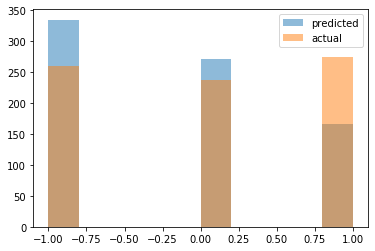

Features: [17, 18, 7, 8]
Column Accuracy: 0.5655440414507773


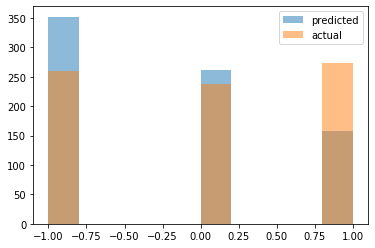

Features: [17, 18, 9, 10]
Column Accuracy: 0.5841968911917098


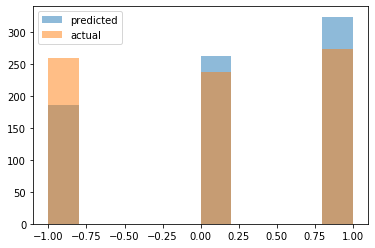

Features: [17, 18, 11, 12]
Column Accuracy: 0.6023316062176166


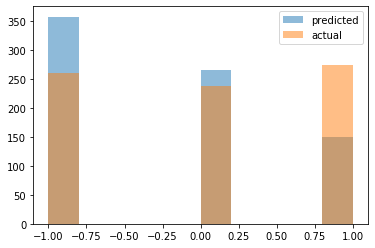

Features: [17, 18, 13, 14]
Column Accuracy: 0.6841968911917098


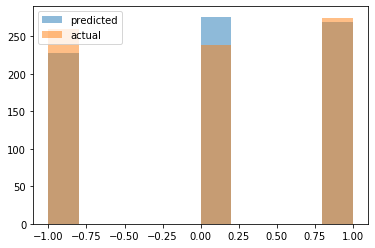

Features: [17, 18, 15, 16]
Column Accuracy: 0.5678756476683938


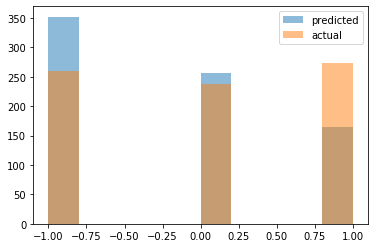

~~~ Choosing Max Cols: [13, 14]
~~~ Max Accuracy: 0.6841968911917098
Remaining Columns: [[0], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [15, 16]]
Features: [17, 18, 13, 14, 0]
Column Accuracy: 0.6844559585492227


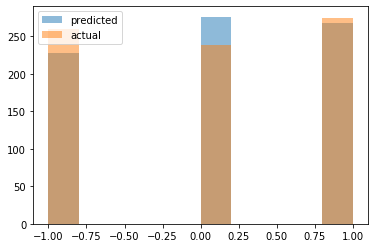

Features: [17, 18, 13, 14, 1, 2]
Column Accuracy: 0.6722797927461139


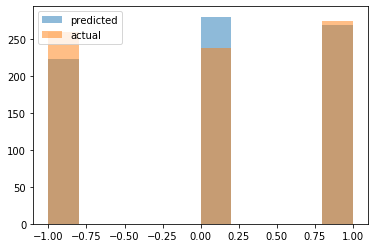

Features: [17, 18, 13, 14, 3, 4]
Column Accuracy: 0.6720207253886011


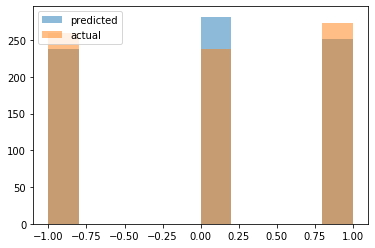

Features: [17, 18, 13, 14, 5, 6]
Column Accuracy: 0.694300518134715


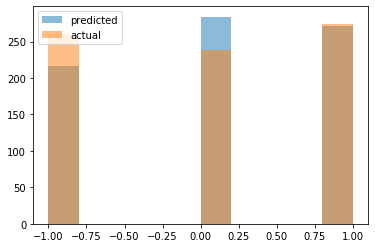

Features: [17, 18, 13, 14, 7, 8]
Column Accuracy: 0.6738341968911916


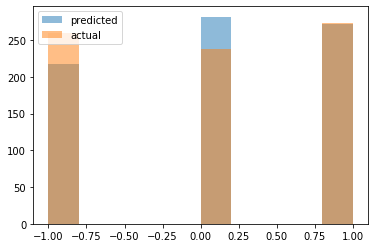

Features: [17, 18, 13, 14, 9, 10]
Column Accuracy: 0.7085492227979274


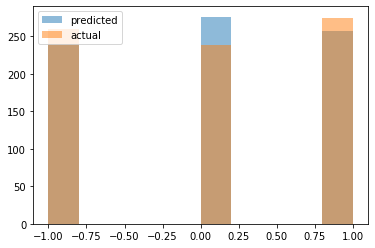

Features: [17, 18, 13, 14, 11, 12]
Column Accuracy: 0.7015544041450777


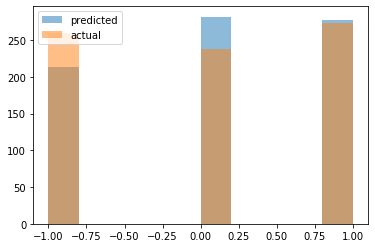

Features: [17, 18, 13, 14, 15, 16]
Column Accuracy: 0.6800518134715026


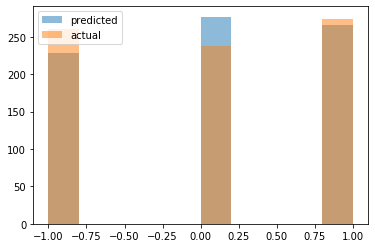

~~~ Choosing Max Cols: [9, 10]
~~~ Max Accuracy: 0.7085492227979274
Remaining Columns: [[0], [1, 2], [3, 4], [5, 6], [7, 8], [11, 12], [15, 16]]
Features: [17, 18, 13, 14, 9, 10, 0]
Column Accuracy: 0.7085492227979274


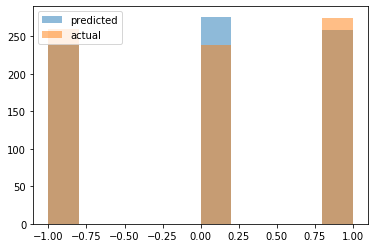

Features: [17, 18, 13, 14, 9, 10, 1, 2]
Column Accuracy: 0.7119170984455958


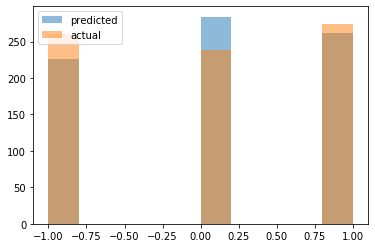

Features: [17, 18, 13, 14, 9, 10, 3, 4]
Column Accuracy: 0.7155440414507772


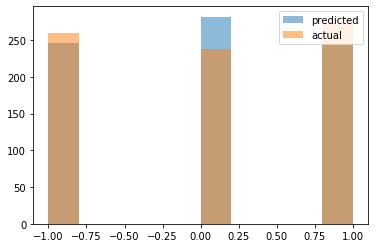

Features: [17, 18, 13, 14, 9, 10, 5, 6]
Column Accuracy: 0.7139896373056994


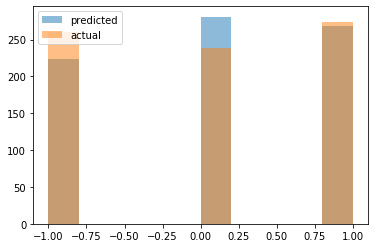

Features: [17, 18, 13, 14, 9, 10, 7, 8]
Column Accuracy: 0.7020725388601037


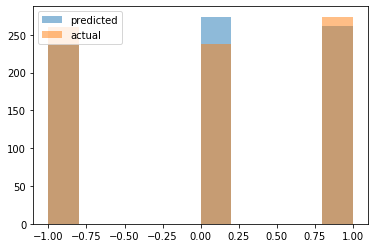

Features: [17, 18, 13, 14, 9, 10, 11, 12]
Column Accuracy: 0.7292746113989638


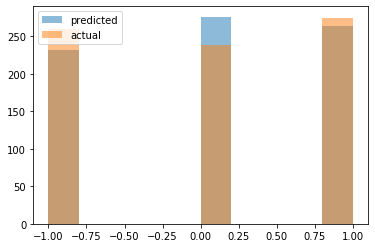

Features: [17, 18, 13, 14, 9, 10, 15, 16]
Column Accuracy: 0.7116580310880829


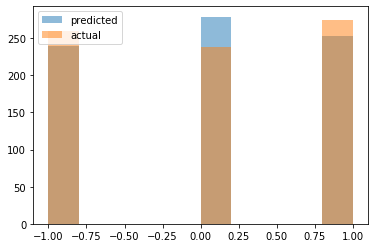

~~~ Choosing Max Cols: [11, 12]
~~~ Max Accuracy: 0.7292746113989638
Remaining Columns: [[0], [1, 2], [3, 4], [5, 6], [7, 8], [15, 16]]
Features: [17, 18, 13, 14, 9, 10, 11, 12, 0]
Column Accuracy: 0.7292746113989638


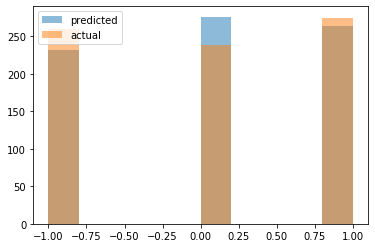

Features: [17, 18, 13, 14, 9, 10, 11, 12, 1, 2]
Column Accuracy: 0.7266839378238342


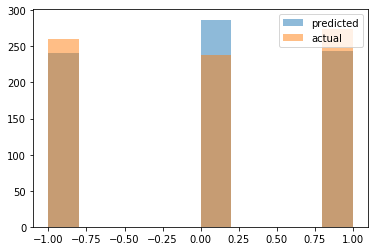

Features: [17, 18, 13, 14, 9, 10, 11, 12, 3, 4]
Column Accuracy: 0.716839378238342


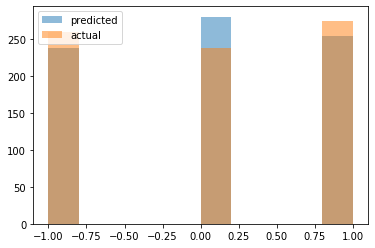

Features: [17, 18, 13, 14, 9, 10, 11, 12, 5, 6]
Column Accuracy: 0.7272020725388602


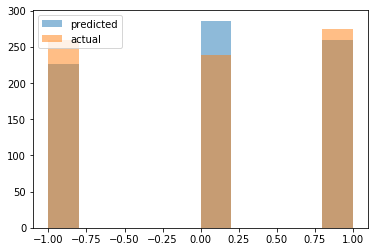

Features: [17, 18, 13, 14, 9, 10, 11, 12, 7, 8]
Column Accuracy: 0.716321243523316


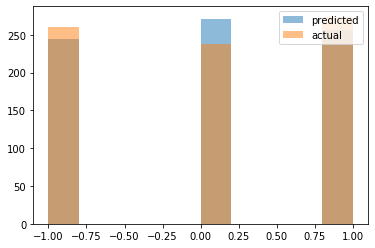

Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16]
Column Accuracy: 0.7375647668393782


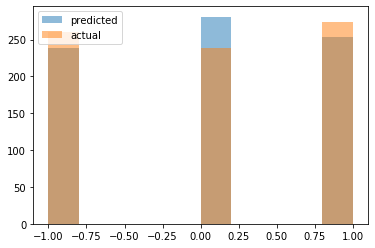

~~~ Choosing Max Cols: [15, 16]
~~~ Max Accuracy: 0.7375647668393782
Remaining Columns: [[0], [1, 2], [3, 4], [5, 6], [7, 8]]
Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 0]
Column Accuracy: 0.7375647668393782


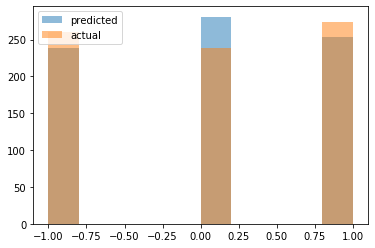

Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 1, 2]
Column Accuracy: 0.7240932642487047


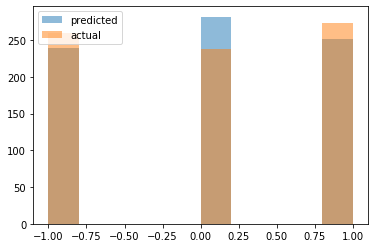

Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 3, 4]
Column Accuracy: 0.7435233160621761


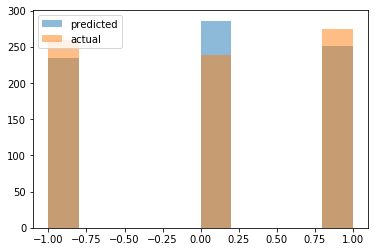

Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 5, 6]
Column Accuracy: 0.7305699481865285


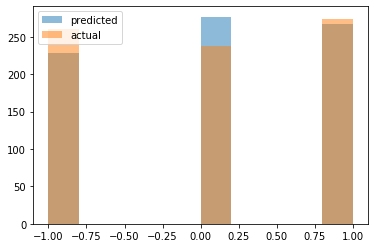

Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 7, 8]
Column Accuracy: 0.7253886010362695


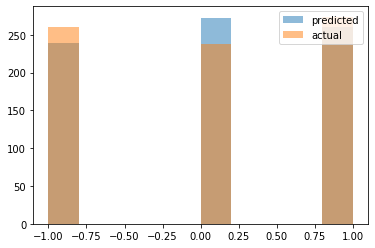

~~~ Choosing Max Cols: [3, 4]
~~~ Max Accuracy: 0.7435233160621761
Remaining Columns: [[0], [1, 2], [5, 6], [7, 8]]
Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 3, 4, 0]
Column Accuracy: 0.7435233160621761


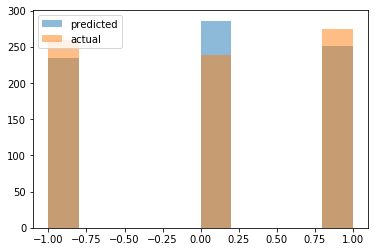

Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 3, 4, 1, 2]
Column Accuracy: 0.7435233160621761


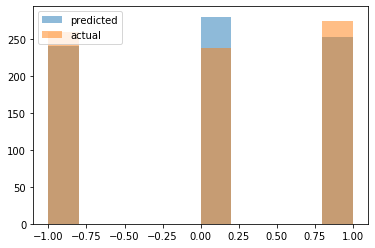

Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 3, 4, 5, 6]
Column Accuracy: 0.7471502590673575


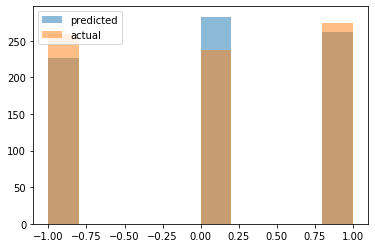

Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 3, 4, 7, 8]
Column Accuracy: 0.7466321243523316


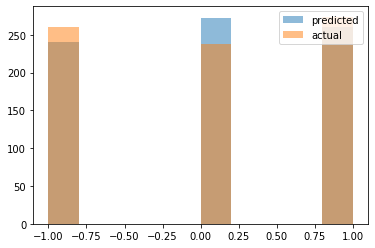

~~~ Choosing Max Cols: [5, 6]
~~~ Max Accuracy: 0.7471502590673575
Remaining Columns: [[0], [1, 2], [7, 8]]
Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 3, 4, 5, 6, 0]
Column Accuracy: 0.7505181347150259


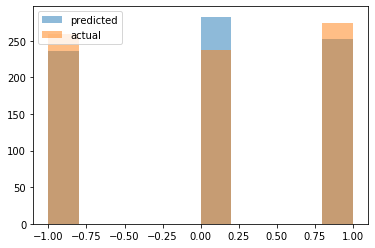

Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 3, 4, 5, 6, 1, 2]
Column Accuracy: 0.7458549222797928


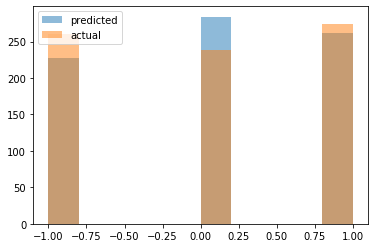

Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 3, 4, 5, 6, 7, 8]
Column Accuracy: 0.7603626943005182


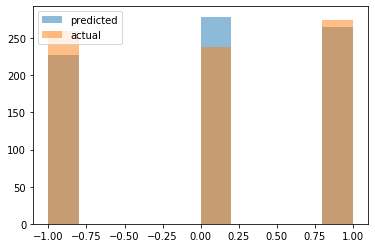

~~~ Choosing Max Cols: [7, 8]
~~~ Max Accuracy: 0.7603626943005182
Remaining Columns: [[0], [1, 2]]
Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 3, 4, 5, 6, 7, 8, 0]
Column Accuracy: 0.7603626943005182


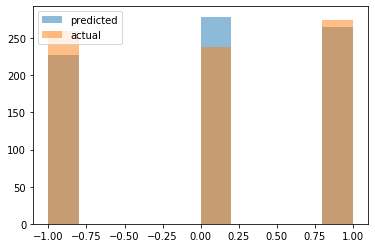

Features: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 3, 4, 5, 6, 7, 8, 1, 2]
Column Accuracy: 0.7536269430051814


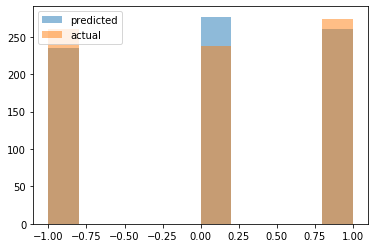

Adding [0] showed no improvement, stopping...
Best Columns found: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 3, 4, 5, 6, 7, 8]
For Period 4 Best Columns found: [17, 18, 13, 14, 9, 10, 11, 12, 15, 16, 3, 4, 5, 6, 7, 8] With accuracy: 0.7603626943005182


In [532]:
x_train = {1:"train_p1_xc", 2:"train_p2_xc", 3:"train_p3_xc", 4:"train_p4_xc"}
y_train = {1:"train_p1_y", 2:"train_p2_y", 3:"train_p3_y", 4:"train_p4_y"}
x_test = {1:"test_p1_xc", 2:"test_p2_xc", 3:"test_p3_xc", 4:"test_p4_xc"}
y_test = {1:"test_p1_y", 2:"test_p2_y", 3:"test_p3_y", 4:"test_p4_y"}

for p in range(1,5):
    col_pairs = [[0],[1,2],[3,4],[5,6],[7,8],[9,10],[11,12],[13,14],[15,16],[17,18]]
    cols = []
    best_acc = 0
    print("Finding Features for Period " + str(p))
    for s in range(len(col_pairs)):
        max_acc = 0
        max_cols = []
        for t in col_pairs:
            tmp2_cols = []
            for m in cols:
                tmp2_cols.append(m)
            for k in t:
                tmp2_cols.append(k)
            print("Features: " + str(tmp2_cols))
            shiftcolData.chooseColumns(tmp2_cols)
            av_col_acc = 0
            for i in range(5):
                g_col = GradientBoostingClassifier(learning_rate=.1, max_depth=3, max_leaf_nodes=50,
                                                   n_estimators=200)
                g_col.fit(getattr(shiftcolData,x_train[p]), getattr(shiftcolData,y_train[p]))
                g_col_pred = g_col.predict(getattr(shiftcolData,x_test[p]))
                av_col_acc += accuracy_score(getattr(shiftcolData,y_test[p]), g_col_pred)
            col_acc = av_col_acc/5
            if col_acc > max_acc:
                max_acc = col_acc
                max_cols = t
            print("Column Accuracy: " + str(col_acc))
            plt.hist(g_col_pred, alpha=0.5, label='predicted')
            plt.hist(getattr(shiftcolData,y_test[p]), alpha=0.5, label='actual')
            plt.legend(loc='best')
            plt.show()
        # add max cols
        if best_acc >= max_acc:
            print("Adding " + str(max_cols) + " showed no improvement, stopping...")
            print("Best Columns found: " + str(cols))
            break
        
        for k in max_cols:
            cols.append(k)
        col_pairs.remove(max_cols)
        print("~~~ Choosing Max Cols: " + str(max_cols))
        print("~~~ Max Accuracy: " + str(max_acc))
        print("Remaining Columns: " + str(col_pairs))
        best_acc = max_acc
    print("For Period " + str(p) + " Best Columns found: " + str(cols) + " With accuracy: " + str(best_acc))

In [562]:
combData = NHL_Period_Data()
combData.binScores(max_bin=1, min_bin=-1)
combData.combineHomeAwayFeatures()
combData.splitByPeriod(comb=True)
combData.trainTestSplit(split=0.2)
#combData.transformPeriodData(encoder="MinMaxScaler")
print(combData.train_p2_x[1])
print(combData.train_p1_x.shape)

[ 0.        -7.         4.        -4.        -2.        -4.
 -2.         5.         2.         3.1711451]
(8994, 10)


Finding Features for Period 1
Features: [0]
Column Accuracy: 0.3534904401956425


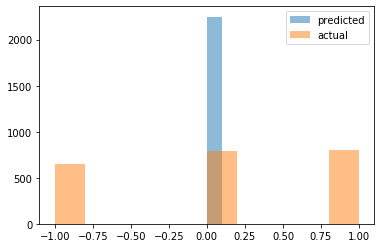

Features: [1]
Column Accuracy: 0.36460649177412185


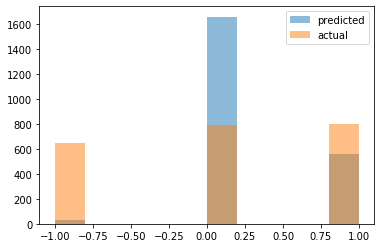

Features: [2]
Column Accuracy: 0.3614939973321476


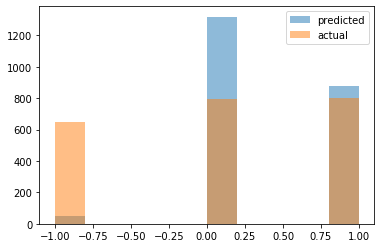

Features: [3]
Column Accuracy: 0.35571365051133835


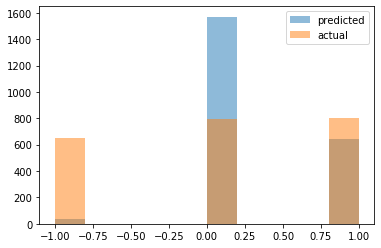

Features: [4]
Column Accuracy: 0.3681636282792352


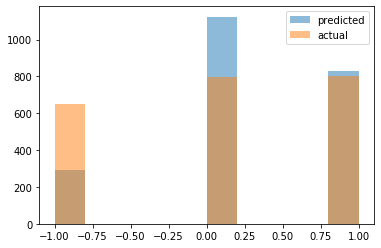

Features: [5]
Column Accuracy: 0.3485993775011116


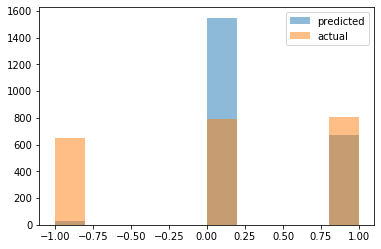

Features: [6]
Column Accuracy: 0.3841707425522454


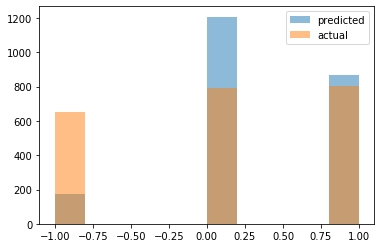

Features: [7]
Column Accuracy: 0.34815473543797243


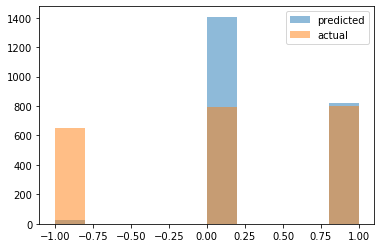

Features: [8]
Column Accuracy: 0.36549577590040017


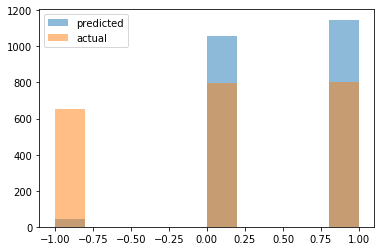

Features: [9]
Column Accuracy: 0.3374833259226323


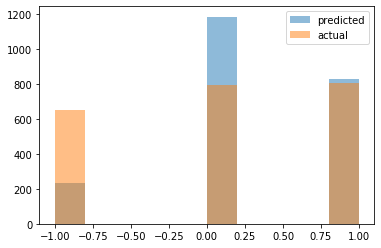

~~~ Choosing Max Cols: [6]
~~~ Max Accuracy: 0.3841707425522454
Remaining Columns: [[0], [1], [2], [3], [4], [5], [7], [8], [9]]
Features: [6, 0]
Column Accuracy: 0.3841707425522454


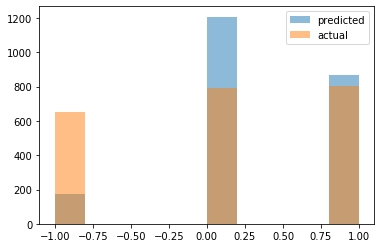

Features: [6, 1]
Column Accuracy: 0.3815028901734104


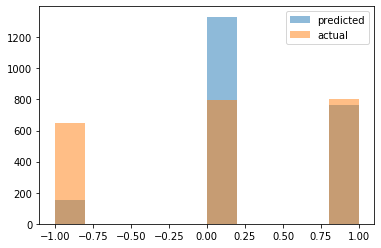

Features: [6, 2]
Column Accuracy: 0.3717207647843486


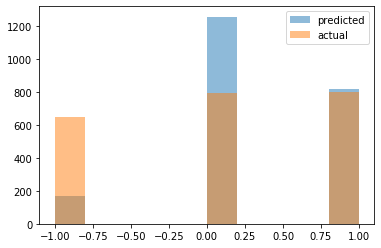

Features: [6, 3]
Column Accuracy: 0.375277901289462


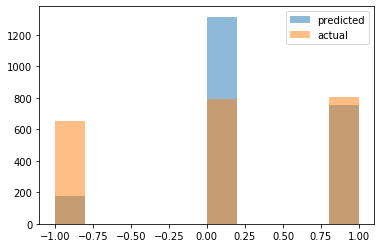

Features: [6, 4]
Column Accuracy: 0.3832814584259671


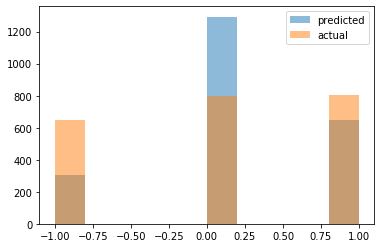

Features: [6, 5]
Column Accuracy: 0.36727434415295684


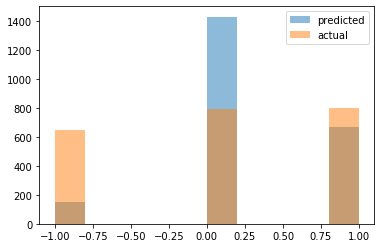

Features: [6, 7]
Column Accuracy: 0.377945753668297


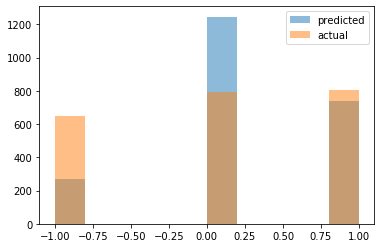

Features: [6, 8]
Column Accuracy: 0.3783903957314362


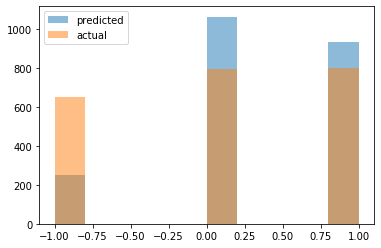

Features: [6, 9]
Column Accuracy: 0.3857714539795465


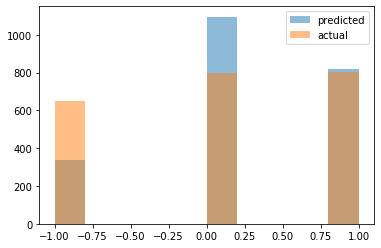

~~~ Choosing Max Cols: [9]
~~~ Max Accuracy: 0.3857714539795465
Remaining Columns: [[0], [1], [2], [3], [4], [5], [7], [8]]
Features: [6, 9, 0]
Column Accuracy: 0.3856825255669186


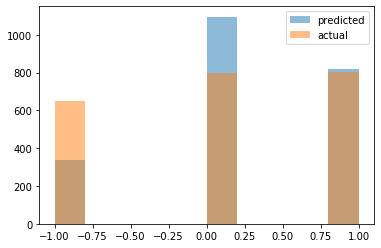

Features: [6, 9, 1]
Column Accuracy: 0.39751000444642065


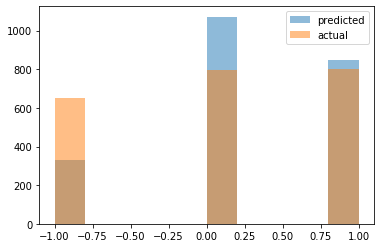

Features: [6, 9, 2]
Column Accuracy: 0.3930635838150289


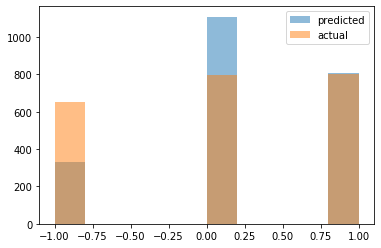

Features: [6, 9, 3]
Column Accuracy: 0.3903957314361939


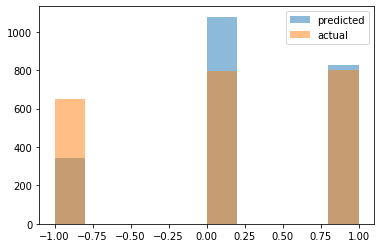

Features: [6, 9, 4]
Column Accuracy: 0.3966207203201423


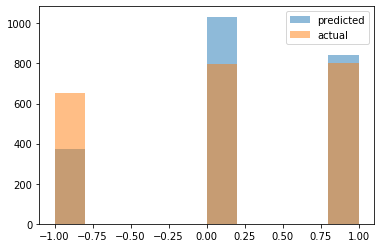

Features: [6, 9, 5]
Column Accuracy: 0.38906180524677636


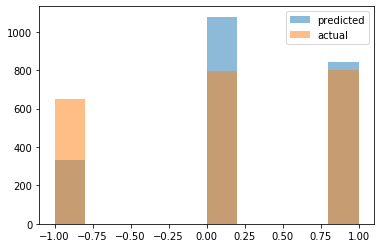

Features: [6, 9, 7]
Column Accuracy: 0.3957314361938639


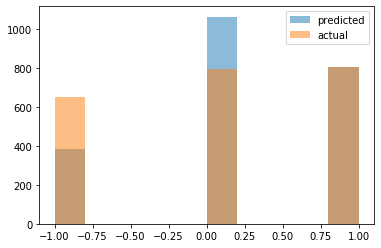

Features: [6, 9, 8]
Column Accuracy: 0.38550466874166295


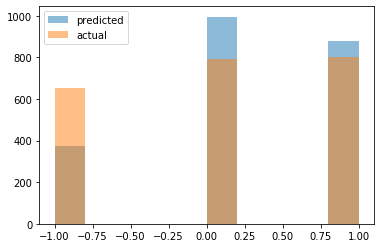

~~~ Choosing Max Cols: [1]
~~~ Max Accuracy: 0.39751000444642065
Remaining Columns: [[0], [2], [3], [4], [5], [7], [8]]
Features: [6, 9, 1, 0]
Column Accuracy: 0.39751000444642065


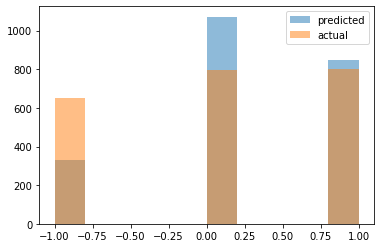

Features: [6, 9, 1, 2]
Column Accuracy: 0.39333036905291247


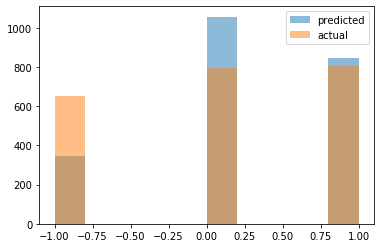

Features: [6, 9, 1, 3]
Column Accuracy: 0.4019564250778124


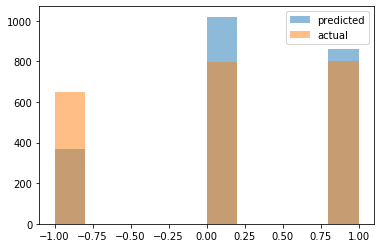

Features: [6, 9, 1, 4]
Column Accuracy: 0.40071142730102266


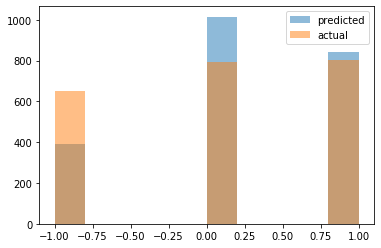

Features: [6, 9, 1, 5]
Column Accuracy: 0.3824811027123166


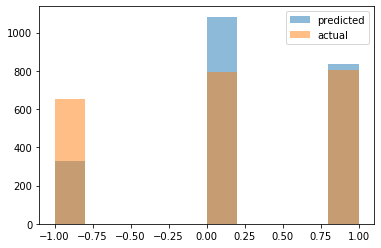

Features: [6, 9, 1, 7]
Column Accuracy: 0.3948421520675856


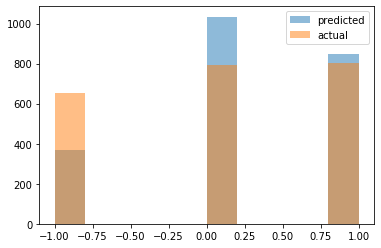

Features: [6, 9, 1, 8]
Column Accuracy: 0.3961760782570031


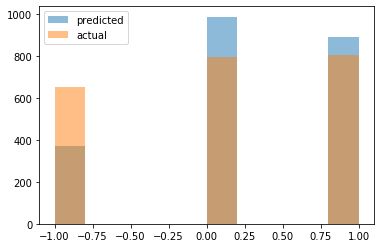

~~~ Choosing Max Cols: [3]
~~~ Max Accuracy: 0.4019564250778124
Remaining Columns: [[0], [2], [4], [5], [7], [8]]
Features: [6, 9, 1, 3, 0]
Column Accuracy: 0.4019564250778124


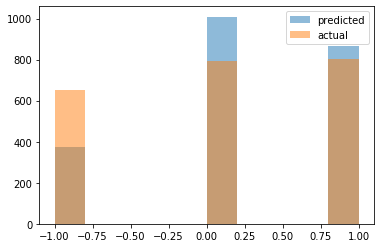

Features: [6, 9, 1, 3, 2]
Column Accuracy: 0.3984882169853268


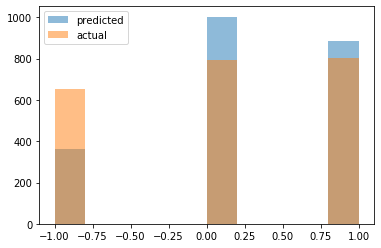

Features: [6, 9, 1, 3, 4]
Column Accuracy: 0.4141396176078257


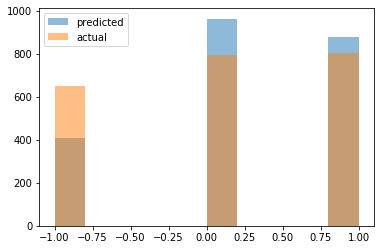

Features: [6, 9, 1, 3, 5]
Column Accuracy: 0.39217429968875056


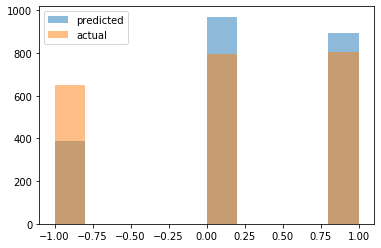

Features: [6, 9, 1, 3, 7]
Column Accuracy: 0.41236104935526907


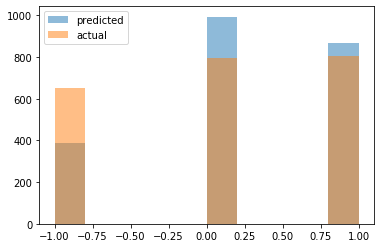

Features: [6, 9, 1, 3, 8]
Column Accuracy: 0.4000889284126279


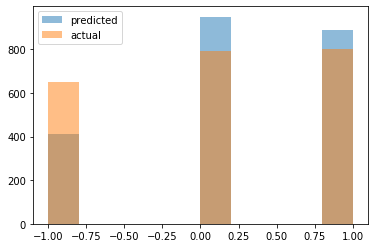

~~~ Choosing Max Cols: [4]
~~~ Max Accuracy: 0.4141396176078257
Remaining Columns: [[0], [2], [5], [7], [8]]
Features: [6, 9, 1, 3, 4, 0]
Column Accuracy: 0.41378390395731435


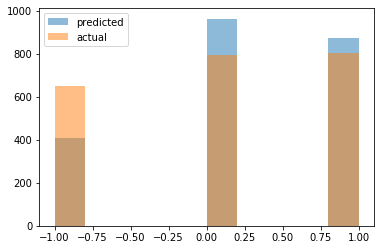

Features: [6, 9, 1, 3, 4, 2]
Column Accuracy: 0.41084926634059576


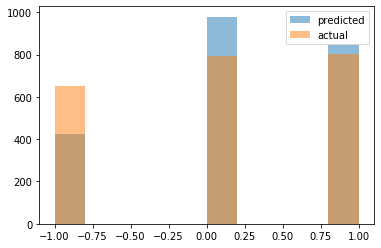

Features: [6, 9, 1, 3, 4, 5]
Column Accuracy: 0.4120942641173855


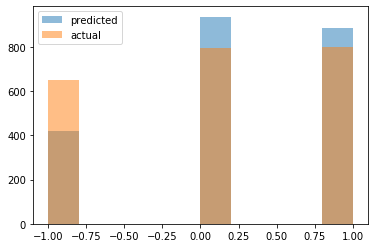

Features: [6, 9, 1, 3, 4, 7]
Column Accuracy: 0.4041796353935082


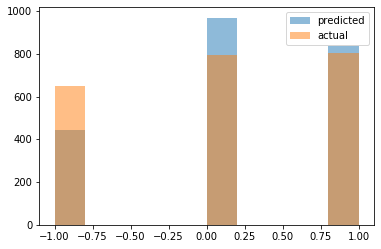

Features: [6, 9, 1, 3, 4, 8]
Column Accuracy: 0.4052467763450423


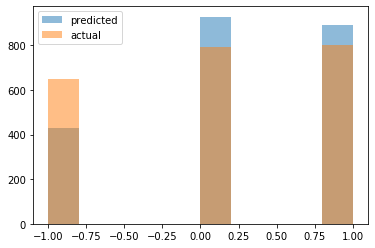

Adding [0] showed no improvement, stopping...
Best Columns found: [6, 9, 1, 3, 4]
For Period 1 Best Columns found: [6, 9, 1, 3, 4] With accuracy: 0.4141396176078257
Finding Features for Period 2
Features: [0]
Column Accuracy: 0.3628279235215651


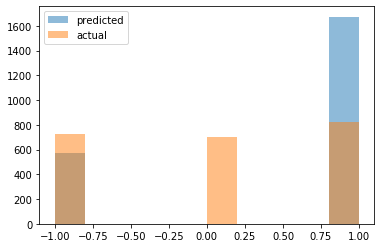

Features: [1]
Column Accuracy: 0.3597154290795909


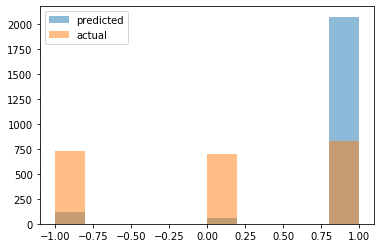

Features: [2]
Column Accuracy: 0.3588261449533126


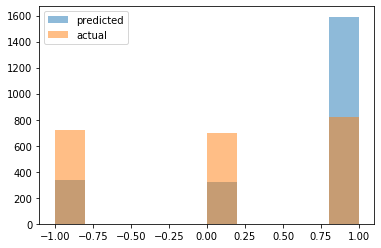

Features: [3]
Column Accuracy: 0.3788350377945754


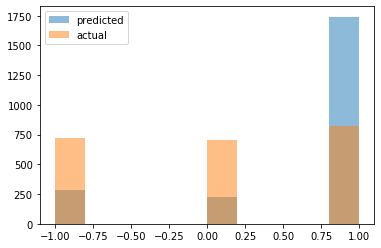

Features: [4]
Column Accuracy: 0.3566029346376167


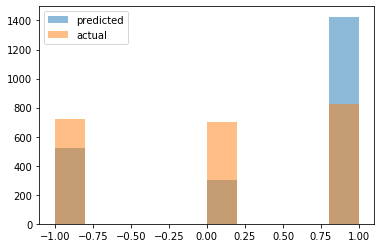

Features: [5]
Column Accuracy: 0.3508225878168075


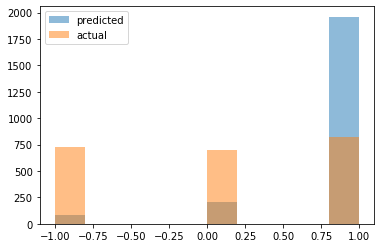

Features: [6]
Column Accuracy: 0.3895064473099155


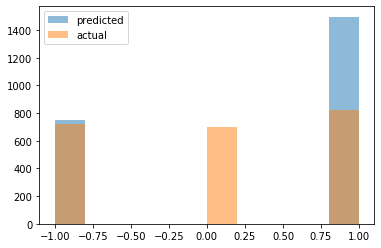

Features: [7]
Column Accuracy: 0.35927078701645176


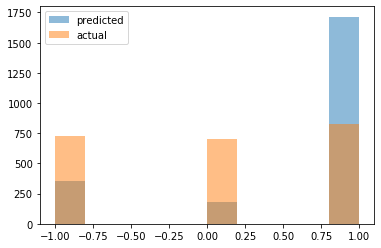

Features: [8]
Column Accuracy: 0.36727434415295684


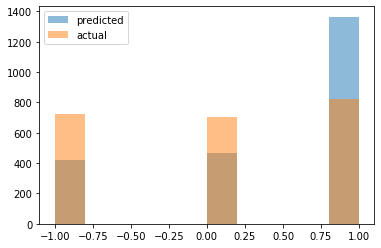

Features: [9]
Column Accuracy: 0.37705646954201866


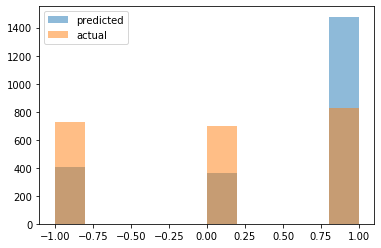

~~~ Choosing Max Cols: [6]
~~~ Max Accuracy: 0.3895064473099155
Remaining Columns: [[0], [1], [2], [3], [4], [5], [7], [8], [9]]
Features: [6, 0]
Column Accuracy: 0.37616718541574035


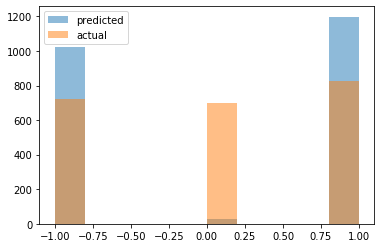

Features: [6, 1]
Column Accuracy: 0.3734993330369053


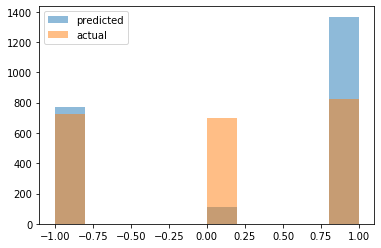

Features: [6, 2]
Column Accuracy: 0.3659404179635394


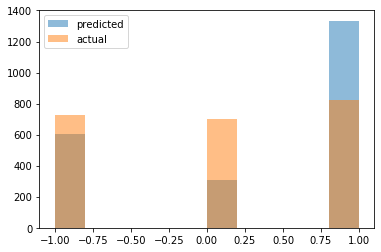

Features: [6, 3]
Column Accuracy: 0.39528679413072476


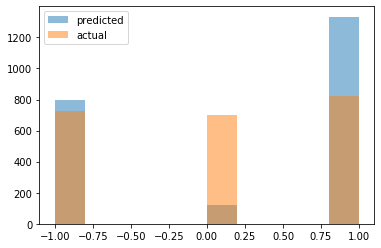

Features: [6, 4]
Column Accuracy: 0.3710093374833259


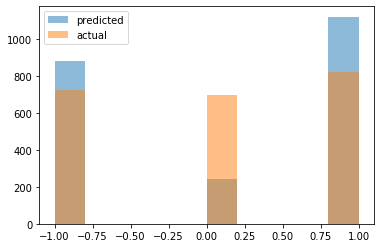

Features: [6, 5]
Column Accuracy: 0.3717207647843486


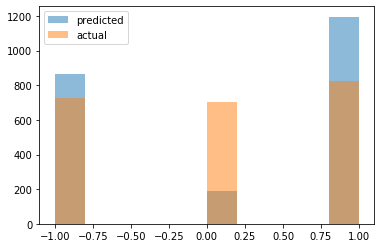

Features: [6, 7]
Column Accuracy: 0.3850600266785238


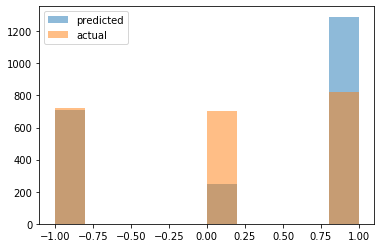

Features: [6, 8]
Column Accuracy: 0.3850600266785238


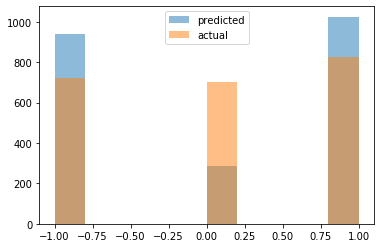

Features: [6, 9]
Column Accuracy: 0.4064917741218319


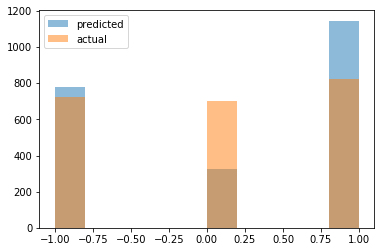

~~~ Choosing Max Cols: [9]
~~~ Max Accuracy: 0.4064917741218319
Remaining Columns: [[0], [1], [2], [3], [4], [5], [7], [8]]
Features: [6, 9, 0]
Column Accuracy: 0.4041796353935082


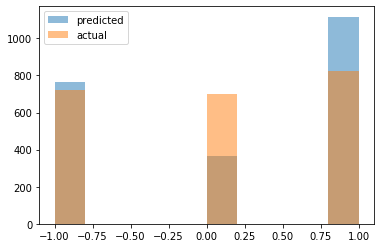

Features: [6, 9, 1]
Column Accuracy: 0.38835037794575367


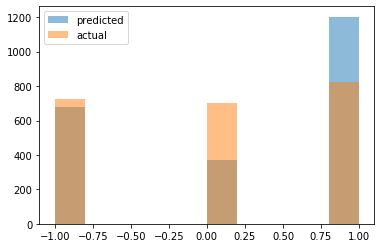

Features: [6, 9, 2]
Column Accuracy: 0.4053357047576701


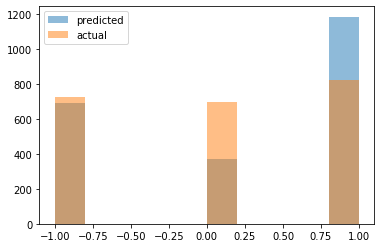

Features: [6, 9, 3]
Column Accuracy: 0.4077367718986216


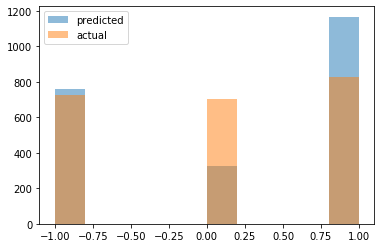

Features: [6, 9, 4]
Column Accuracy: 0.3917296576256114


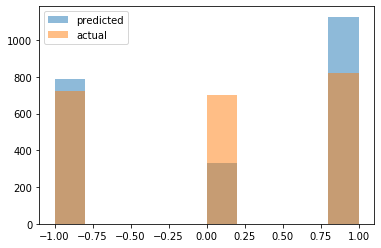

Features: [6, 9, 5]
Column Accuracy: 0.39706536238328144


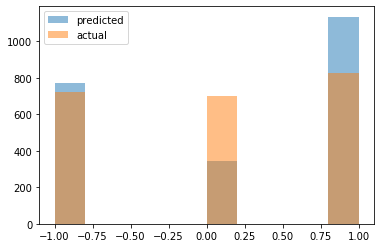

Features: [6, 9, 7]
Column Accuracy: 0.4095153401511783


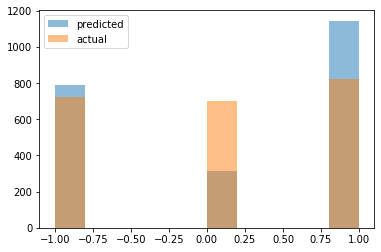

Features: [6, 9, 8]
Column Accuracy: 0.4055135615829258


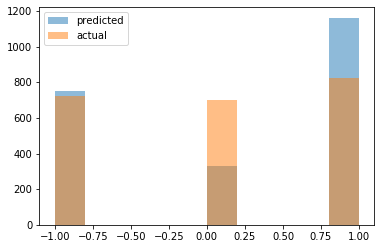

~~~ Choosing Max Cols: [7]
~~~ Max Accuracy: 0.4095153401511783
Remaining Columns: [[0], [1], [2], [3], [4], [5], [8]]
Features: [6, 9, 7, 0]
Column Accuracy: 0.4133392618941752


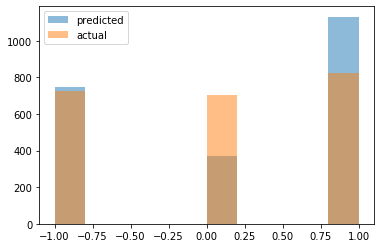

Features: [6, 9, 7, 1]
Column Accuracy: 0.39919964428634946


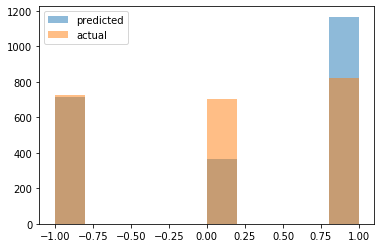

Features: [6, 9, 7, 2]
Column Accuracy: 0.39751000444642065


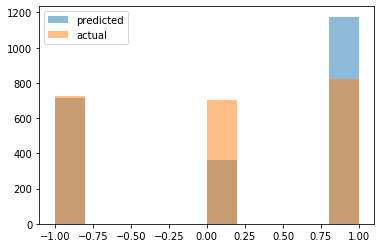

Features: [6, 9, 7, 3]
Column Accuracy: 0.41351711871943087


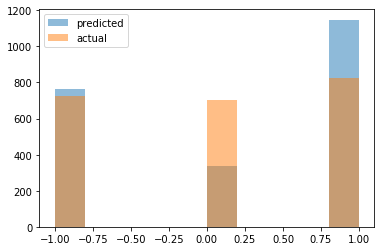

Features: [6, 9, 7, 4]
Column Accuracy: 0.40062249888839485


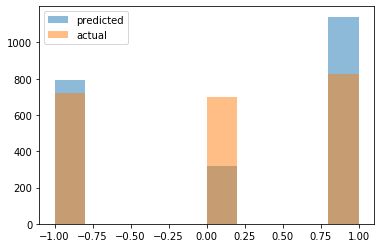

Features: [6, 9, 7, 5]
Column Accuracy: 0.3974210760337928


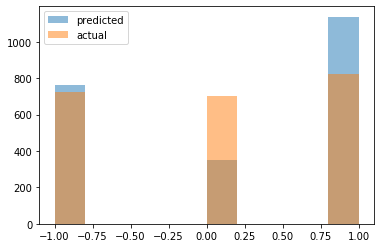

Features: [6, 9, 7, 8]
Column Accuracy: 0.40062249888839485


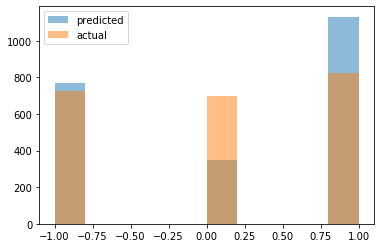

~~~ Choosing Max Cols: [3]
~~~ Max Accuracy: 0.41351711871943087
Remaining Columns: [[0], [1], [2], [4], [5], [8]]
Features: [6, 9, 7, 3, 0]
Column Accuracy: 0.3979546465095598


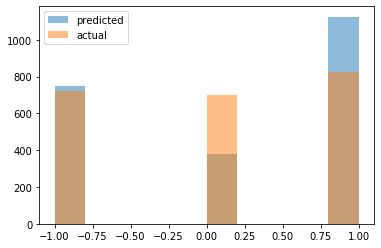

Features: [6, 9, 7, 3, 1]
Column Accuracy: 0.4090706980880391


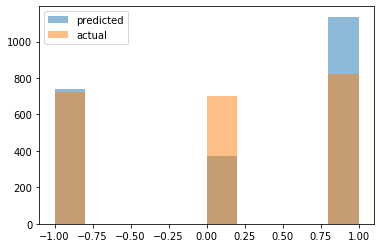

Features: [6, 9, 7, 3, 2]
Column Accuracy: 0.400533570475767


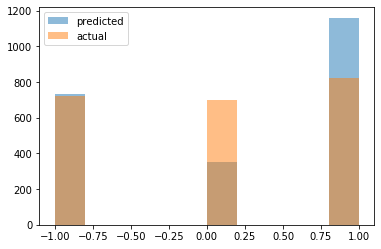

Features: [6, 9, 7, 3, 4]
Column Accuracy: 0.40177856825255676


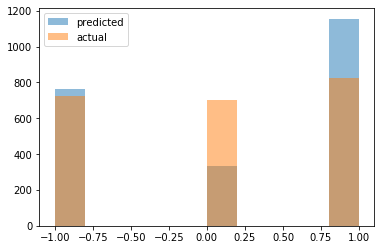

Features: [6, 9, 7, 3, 5]
Column Accuracy: 0.40240106714095153


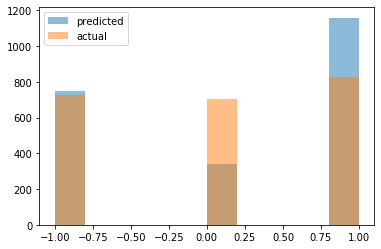

Features: [6, 9, 7, 3, 8]
Column Accuracy: 0.4058692752334371


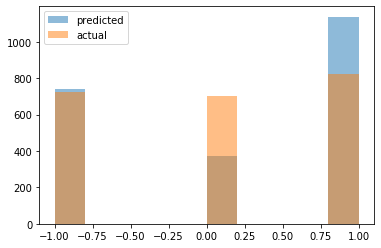

Adding [1] showed no improvement, stopping...
Best Columns found: [6, 9, 7, 3]
For Period 2 Best Columns found: [6, 9, 7, 3] With accuracy: 0.41351711871943087
Finding Features for Period 3
Features: [0]
Column Accuracy: 0.39706536238328144


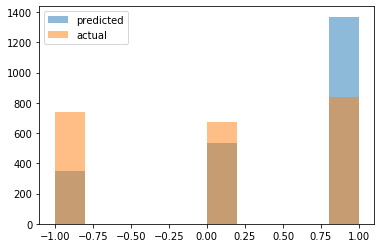

Features: [1]
Column Accuracy: 0.4028457092040907


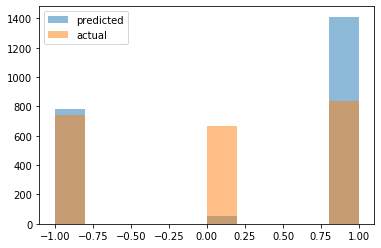

Features: [2]
Column Accuracy: 0.37305469097376615


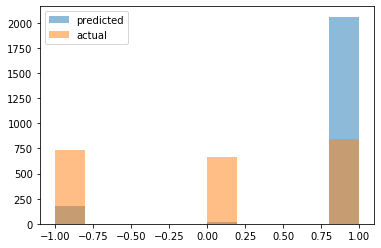

Features: [3]
Column Accuracy: 0.3734993330369053


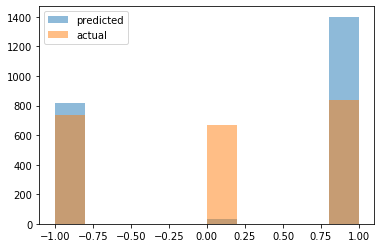

Features: [4]
Column Accuracy: 0.36416184971098264


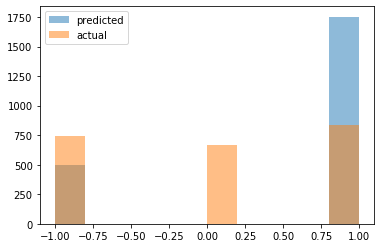

Features: [5]
Column Accuracy: 0.3717207647843486


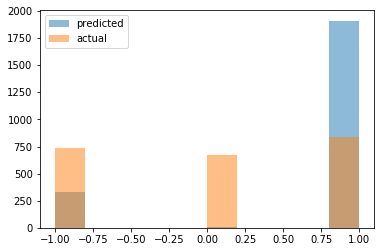

Features: [6]
Column Accuracy: 0.3943975100044464


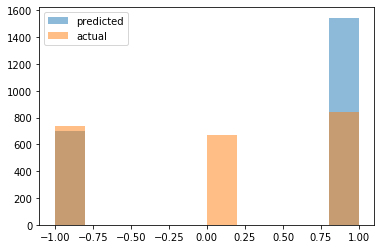

Features: [7]
Column Accuracy: 0.3721654068474878


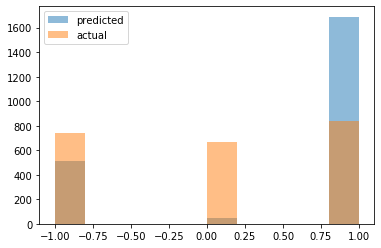

Features: [8]
Column Accuracy: 0.3943975100044464


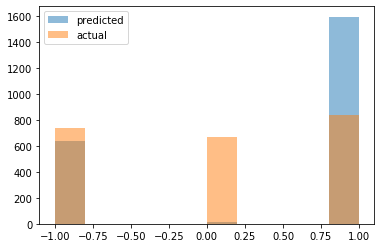

Features: [9]
Column Accuracy: 0.38594931080480216


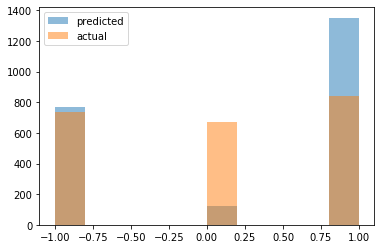

~~~ Choosing Max Cols: [1]
~~~ Max Accuracy: 0.4028457092040907
Remaining Columns: [[0], [2], [3], [4], [5], [6], [7], [8], [9]]
Features: [1, 0]
Column Accuracy: 0.43085815918185866


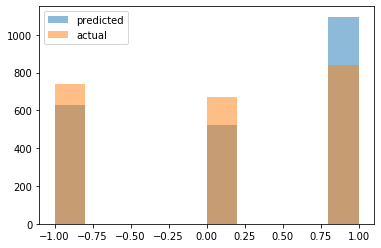

Features: [1, 2]
Column Accuracy: 0.4028457092040907


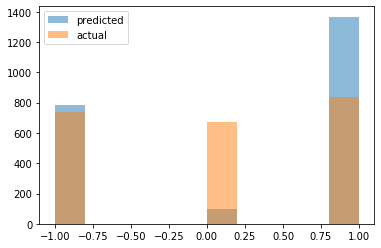

Features: [1, 3]
Column Accuracy: 0.4028457092040907


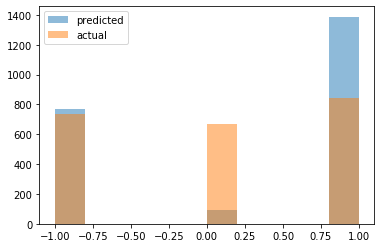

Features: [1, 4]
Column Accuracy: 0.4040907069808804


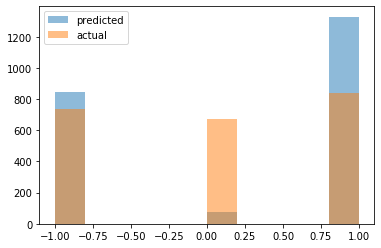

Features: [1, 5]
Column Accuracy: 0.3988439306358382


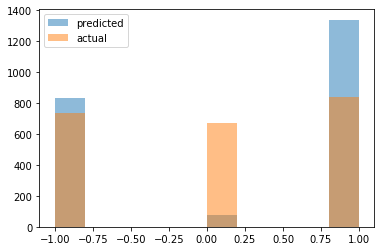

Features: [1, 6]
Column Accuracy: 0.42152067585593594


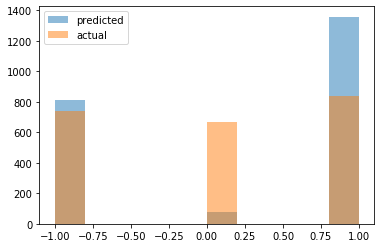

Features: [1, 7]
Column Accuracy: 0.3966207203201423


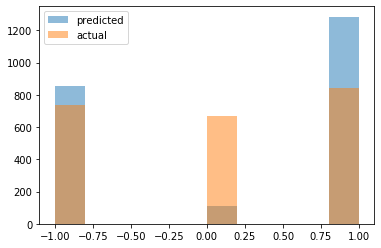

Features: [1, 8]
Column Accuracy: 0.4028457092040907


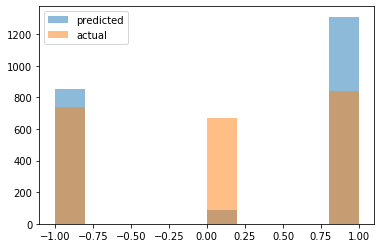

Features: [1, 9]
Column Accuracy: 0.39395286794130724


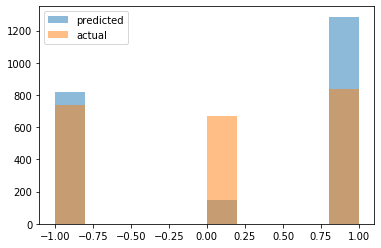

~~~ Choosing Max Cols: [0]
~~~ Max Accuracy: 0.43085815918185866
Remaining Columns: [[2], [3], [4], [5], [6], [7], [8], [9]]
Features: [1, 0, 2]
Column Accuracy: 0.42027567807914623


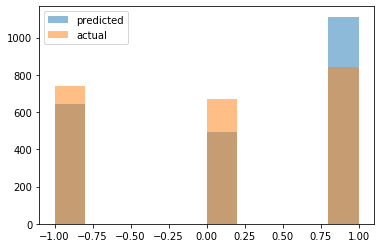

Features: [1, 0, 3]
Column Accuracy: 0.430057803468208


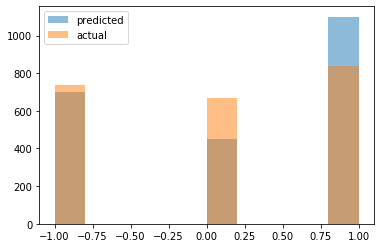

Features: [1, 0, 4]
Column Accuracy: 0.4240995998221432


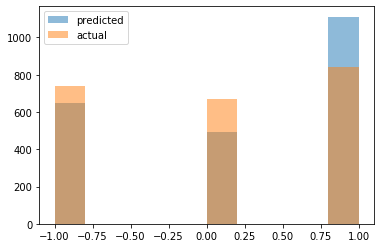

Features: [1, 0, 5]
Column Accuracy: 0.416629613161405


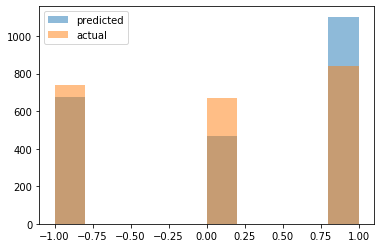

Features: [1, 0, 6]
Column Accuracy: 0.44775455758114713


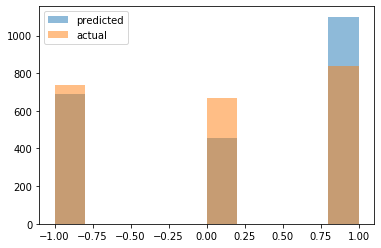

Features: [1, 0, 7]
Column Accuracy: 0.4192974655402401


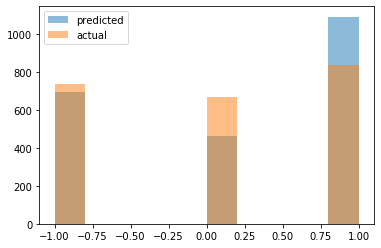

Features: [1, 0, 8]
Column Accuracy: 0.4321920853712761


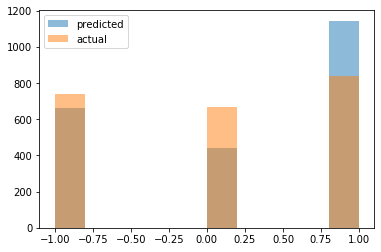

Features: [1, 0, 9]
Column Accuracy: 0.43441529568697207


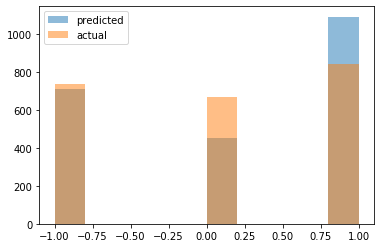

~~~ Choosing Max Cols: [6]
~~~ Max Accuracy: 0.44775455758114713
Remaining Columns: [[2], [3], [4], [5], [7], [8], [9]]
Features: [1, 0, 6, 2]
Column Accuracy: 0.4469542018674966


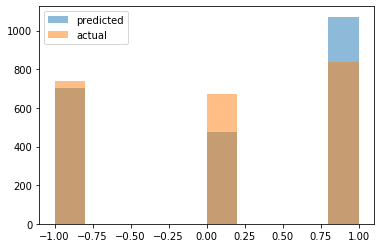

Features: [1, 0, 6, 3]
Column Accuracy: 0.4495331258337038


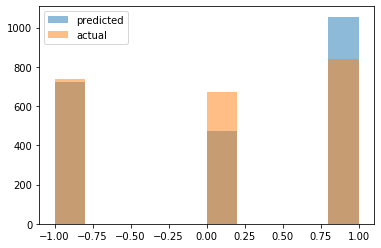

Features: [1, 0, 6, 4]
Column Accuracy: 0.4438417074255224


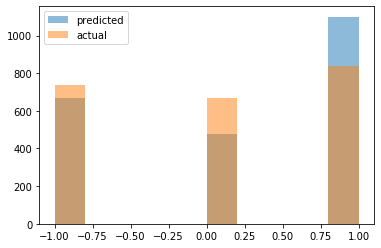

Features: [1, 0, 6, 5]
Column Accuracy: 0.444642063139173


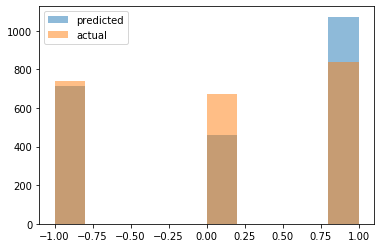

Features: [1, 0, 6, 7]
Column Accuracy: 0.45264562027567806


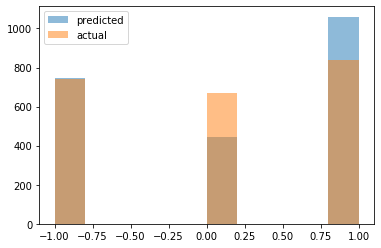

Features: [1, 0, 6, 8]
Column Accuracy: 0.4539795464650956


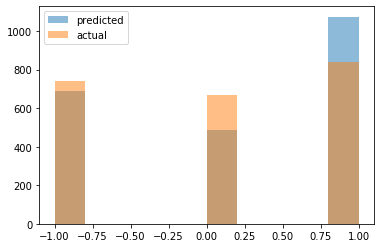

Features: [1, 0, 6, 9]
Column Accuracy: 0.4626945309026234


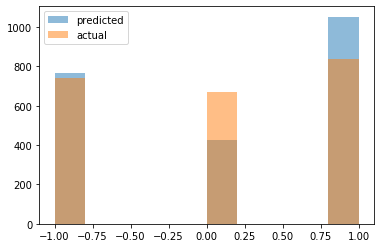

~~~ Choosing Max Cols: [9]
~~~ Max Accuracy: 0.4626945309026234
Remaining Columns: [[2], [3], [4], [5], [7], [8]]
Features: [1, 0, 6, 9, 2]
Column Accuracy: 0.45228990662516677


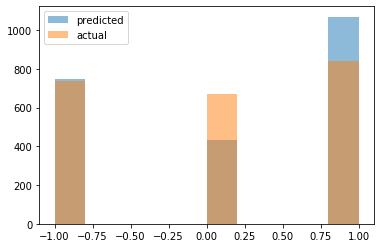

Features: [1, 0, 6, 9, 3]
Column Accuracy: 0.4677634504224099


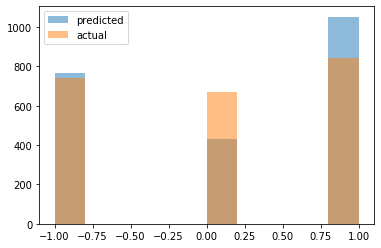

Features: [1, 0, 6, 9, 4]
Column Accuracy: 0.4656291685193419


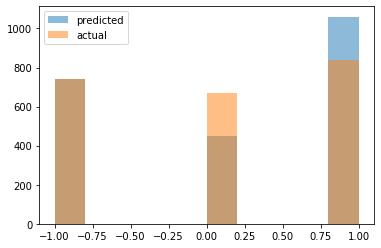

Features: [1, 0, 6, 9, 5]
Column Accuracy: 0.44722098710538016


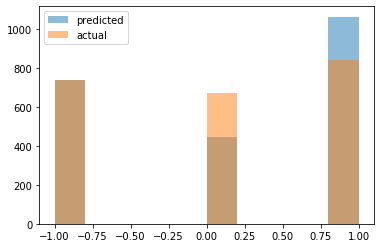

Features: [1, 0, 6, 9, 7]
Column Accuracy: 0.4588706091596265


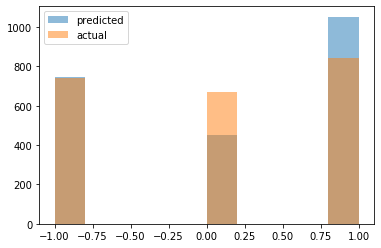

Features: [1, 0, 6, 9, 8]
Column Accuracy: 0.4634948866162739


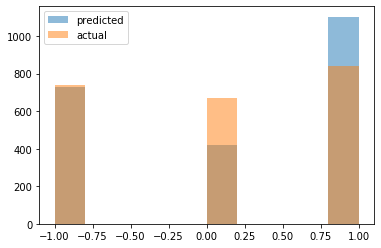

~~~ Choosing Max Cols: [3]
~~~ Max Accuracy: 0.4677634504224099
Remaining Columns: [[2], [4], [5], [7], [8]]
Features: [1, 0, 6, 9, 3, 2]
Column Accuracy: 0.4642063139172966


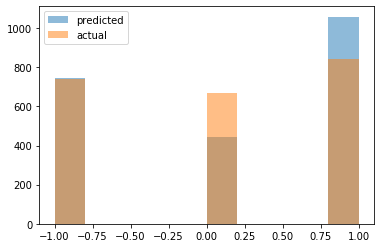

Features: [1, 0, 6, 9, 3, 4]
Column Accuracy: 0.4666073810582481


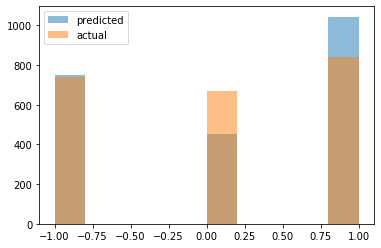

Features: [1, 0, 6, 9, 3, 5]
Column Accuracy: 0.46047132058692747


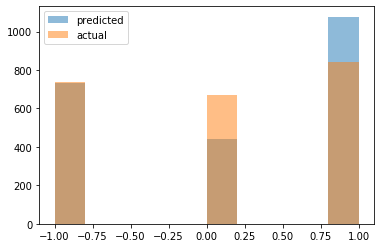

Features: [1, 0, 6, 9, 3, 7]
Column Accuracy: 0.4619831036016008


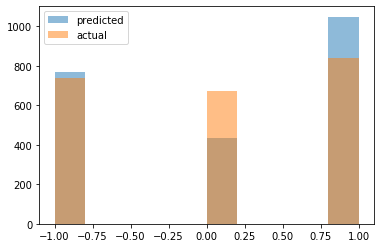

Features: [1, 0, 6, 9, 3, 8]
Column Accuracy: 0.4742552245442419


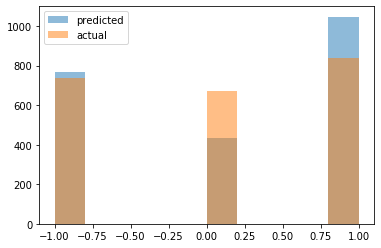

~~~ Choosing Max Cols: [8]
~~~ Max Accuracy: 0.4742552245442419
Remaining Columns: [[2], [4], [5], [7]]
Features: [1, 0, 6, 9, 3, 8, 2]
Column Accuracy: 0.4748777234326368


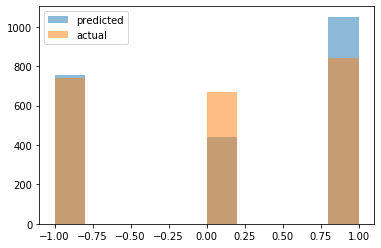

Features: [1, 0, 6, 9, 3, 8, 4]
Column Accuracy: 0.483325922632281


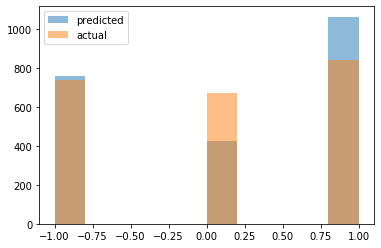

Features: [1, 0, 6, 9, 3, 8, 5]
Column Accuracy: 0.46874166296131614


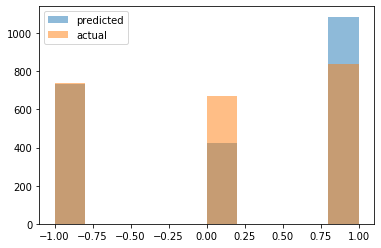

Features: [1, 0, 6, 9, 3, 8, 7]
Column Accuracy: 0.4713205869275233


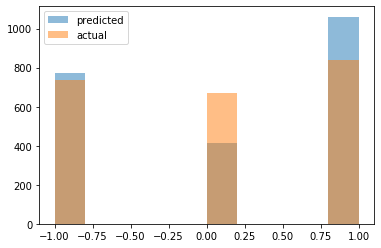

~~~ Choosing Max Cols: [4]
~~~ Max Accuracy: 0.483325922632281
Remaining Columns: [[2], [5], [7]]
Features: [1, 0, 6, 9, 3, 8, 4, 2]
Column Accuracy: 0.48074699866607384


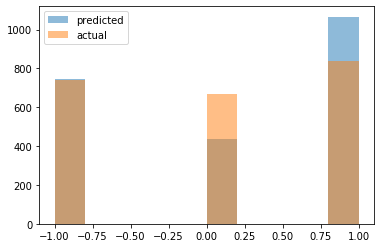

Features: [1, 0, 6, 9, 3, 8, 4, 5]
Column Accuracy: 0.4736327256558471


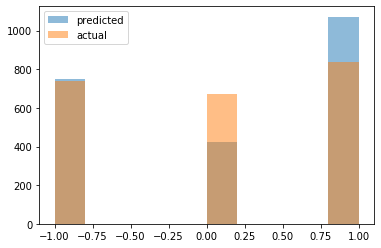

Features: [1, 0, 6, 9, 3, 8, 4, 7]
Column Accuracy: 0.47630057803468207


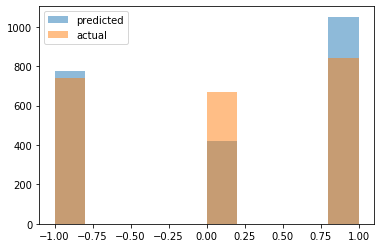

Adding [2] showed no improvement, stopping...
Best Columns found: [1, 0, 6, 9, 3, 8, 4]
For Period 3 Best Columns found: [1, 0, 6, 9, 3, 8, 4] With accuracy: 0.483325922632281
Finding Features for Period 4
Features: [0]
Column Accuracy: 0.3471502590673575


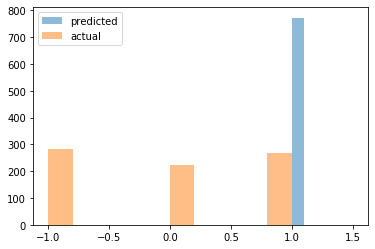

Features: [1]
Column Accuracy: 0.4494818652849741


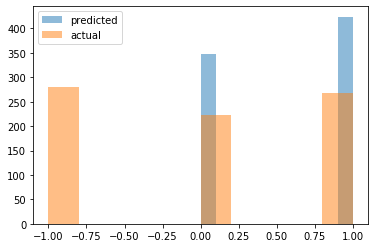

Features: [2]
Column Accuracy: 0.41968911917098445


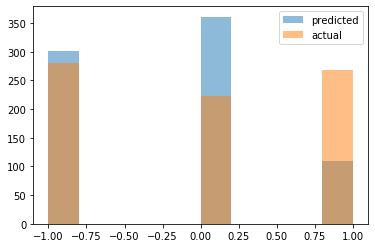

Features: [3]
Column Accuracy: 0.4430051813471502


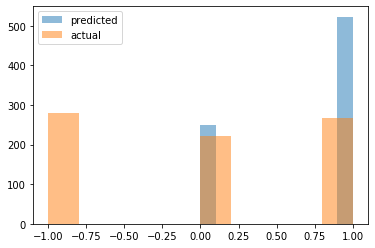

Features: [4]
Column Accuracy: 0.4572538860103627


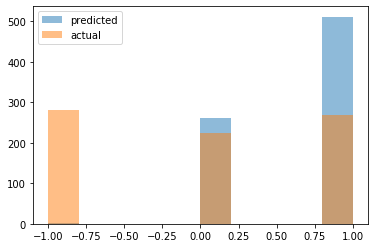

Features: [5]
Column Accuracy: 0.43264248704663205


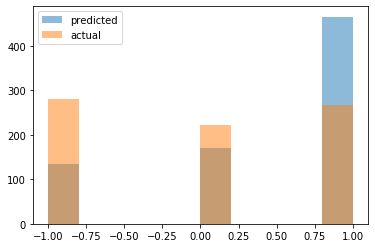

Features: [6]
Column Accuracy: 0.3950777202072539


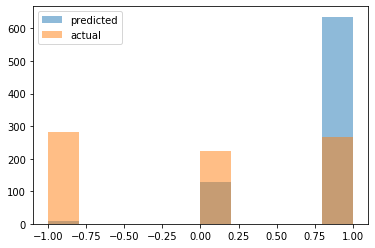

Features: [7]
Column Accuracy: 0.4650259067357513


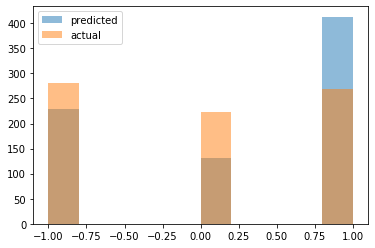

Features: [8]
Column Accuracy: 0.43652849740932637


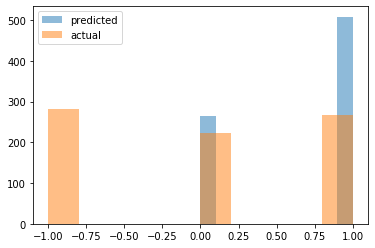

Features: [9]
Column Accuracy: 0.4404145077720207


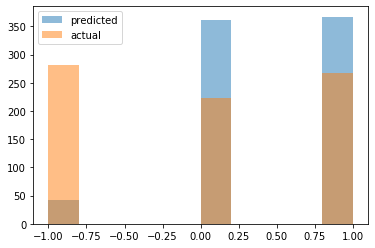

~~~ Choosing Max Cols: [7]
~~~ Max Accuracy: 0.4650259067357513
Remaining Columns: [[0], [1], [2], [3], [4], [5], [6], [8], [9]]
Features: [7, 0]
Column Accuracy: 0.4650259067357513


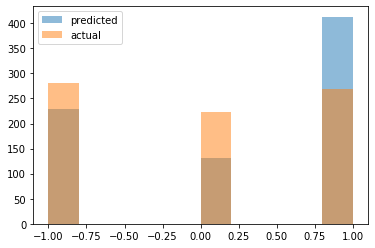

Features: [7, 1]
Column Accuracy: 0.5349740932642487


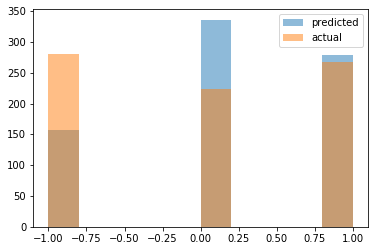

Features: [7, 2]
Column Accuracy: 0.5155440414507773


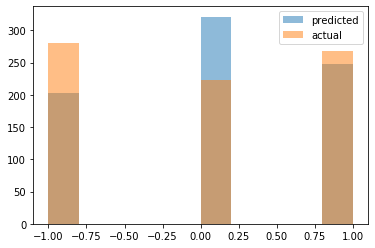

Features: [7, 3]
Column Accuracy: 0.5194300518134715


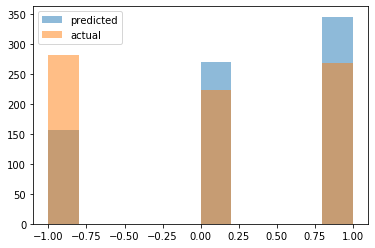

Features: [7, 4]
Column Accuracy: 0.533678756476684


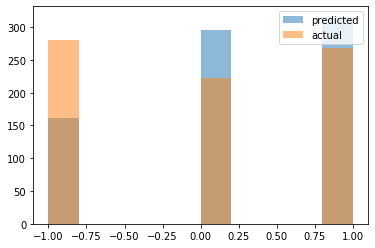

Features: [7, 5]
Column Accuracy: 0.582901554404145


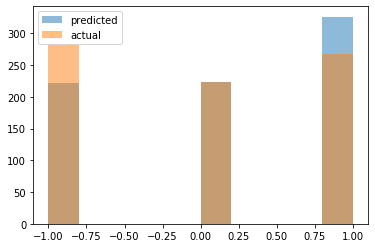

Features: [7, 6]
Column Accuracy: 0.5116580310880829


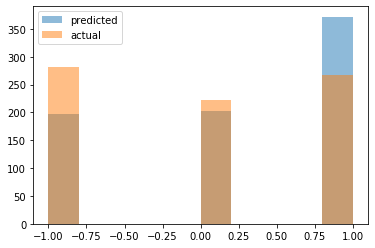

Features: [7, 8]
Column Accuracy: 0.5194300518134715


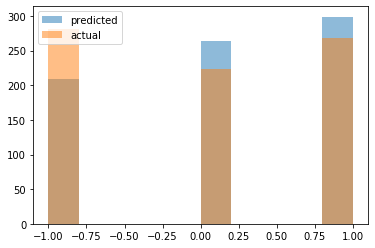

Features: [7, 9]
Column Accuracy: 0.5518134715025906


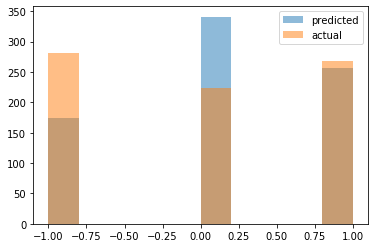

~~~ Choosing Max Cols: [5]
~~~ Max Accuracy: 0.582901554404145
Remaining Columns: [[0], [1], [2], [3], [4], [6], [8], [9]]
Features: [7, 5, 0]
Column Accuracy: 0.582901554404145


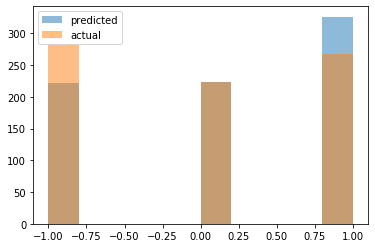

Features: [7, 5, 1]
Column Accuracy: 0.5867875647668394


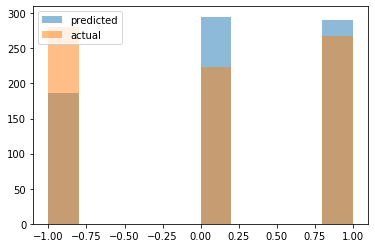

Features: [7, 5, 2]
Column Accuracy: 0.6012953367875647


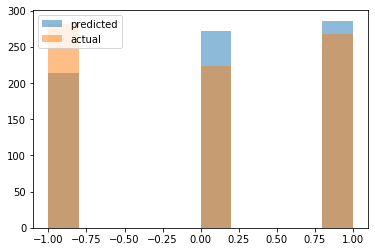

Features: [7, 5, 3]
Column Accuracy: 0.6


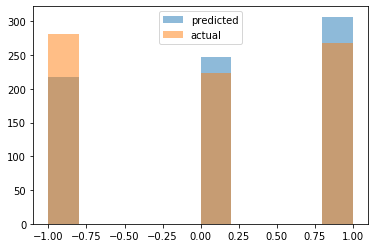

Features: [7, 5, 4]
Column Accuracy: 0.6075129533678757


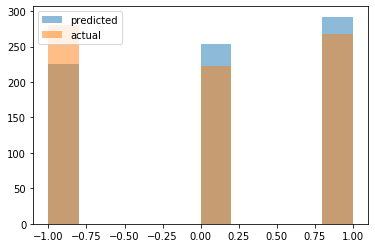

Features: [7, 5, 6]
Column Accuracy: 0.5852331606217616


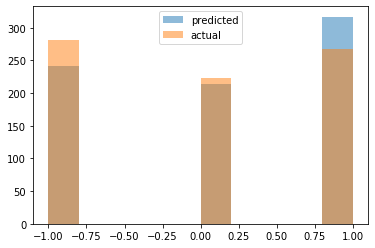

Features: [7, 5, 8]
Column Accuracy: 0.6038860103626943


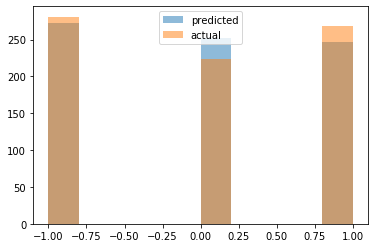

Features: [7, 5, 9]
Column Accuracy: 0.5919689119170984


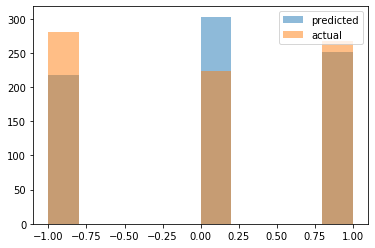

~~~ Choosing Max Cols: [4]
~~~ Max Accuracy: 0.6075129533678757
Remaining Columns: [[0], [1], [2], [3], [6], [8], [9]]
Features: [7, 5, 4, 0]
Column Accuracy: 0.6075129533678757


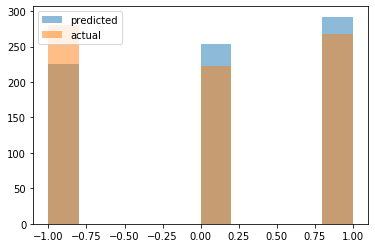

Features: [7, 5, 4, 1]
Column Accuracy: 0.616580310880829


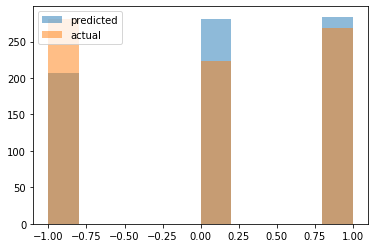

Features: [7, 5, 4, 2]
Column Accuracy: 0.6137305699481865


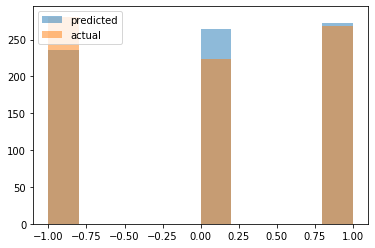

Features: [7, 5, 4, 3]
Column Accuracy: 0.610880829015544


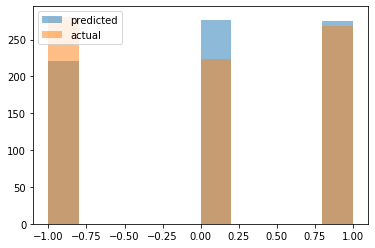

Features: [7, 5, 4, 6]
Column Accuracy: 0.6168393782383419


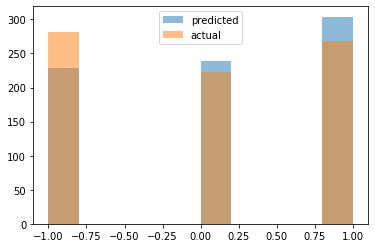

Features: [7, 5, 4, 8]
Column Accuracy: 0.6191709844559585


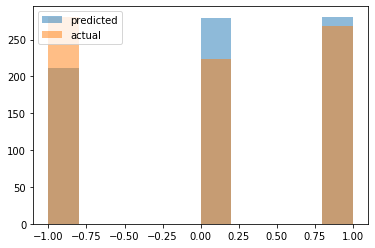

Features: [7, 5, 4, 9]
Column Accuracy: 0.5984455958549223


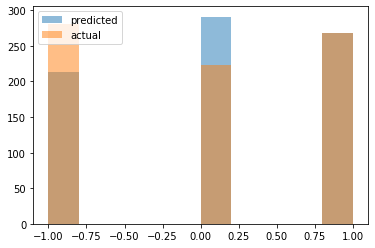

~~~ Choosing Max Cols: [8]
~~~ Max Accuracy: 0.6191709844559585
Remaining Columns: [[0], [1], [2], [3], [6], [9]]
Features: [7, 5, 4, 8, 0]
Column Accuracy: 0.6191709844559585


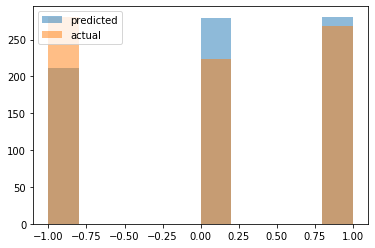

Features: [7, 5, 4, 8, 1]
Column Accuracy: 0.6113989637305699


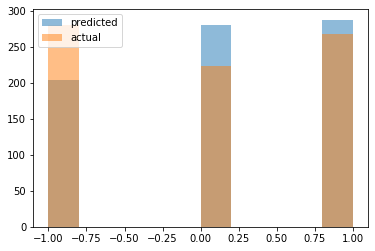

Features: [7, 5, 4, 8, 2]
Column Accuracy: 0.6308290155440415


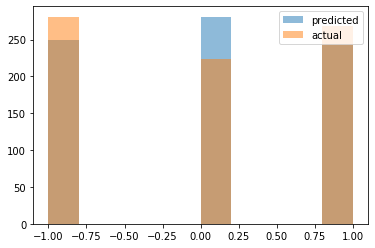

Features: [7, 5, 4, 8, 3]
Column Accuracy: 0.6321243523316062


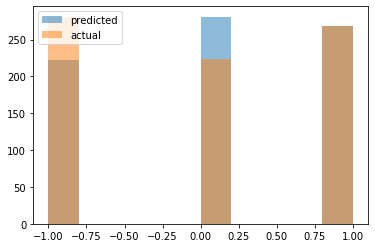

Features: [7, 5, 4, 8, 6]
Column Accuracy: 0.6264248704663212


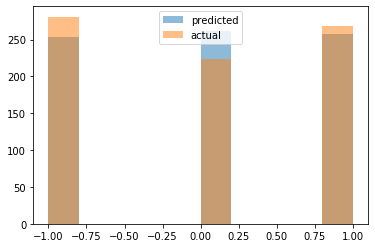

Features: [7, 5, 4, 8, 9]
Column Accuracy: 0.6023316062176166


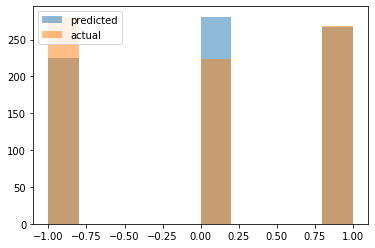

~~~ Choosing Max Cols: [3]
~~~ Max Accuracy: 0.6321243523316062
Remaining Columns: [[0], [1], [2], [6], [9]]
Features: [7, 5, 4, 8, 3, 0]
Column Accuracy: 0.6329015544041451


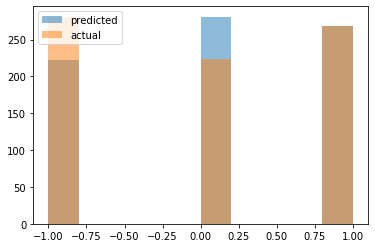

Features: [7, 5, 4, 8, 3, 1]
Column Accuracy: 0.633937823834197


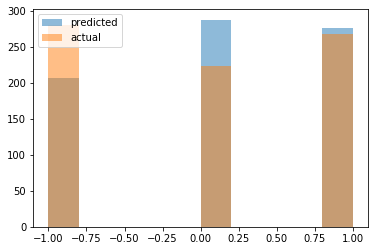

Features: [7, 5, 4, 8, 3, 2]
Column Accuracy: 0.6297927461139896


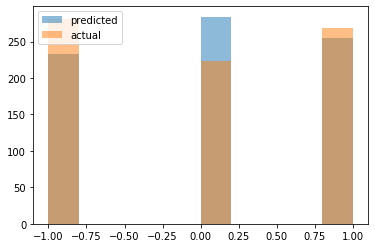

Features: [7, 5, 4, 8, 3, 6]
Column Accuracy: 0.6326424870466322


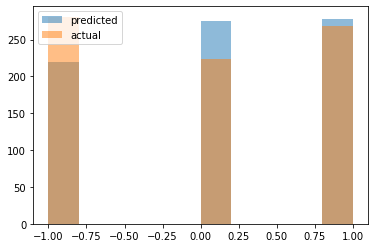

Features: [7, 5, 4, 8, 3, 9]
Column Accuracy: 0.6181347150259067


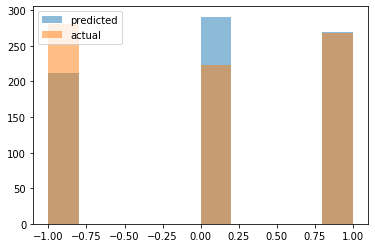

~~~ Choosing Max Cols: [1]
~~~ Max Accuracy: 0.633937823834197
Remaining Columns: [[0], [2], [6], [9]]
Features: [7, 5, 4, 8, 3, 1, 0]
Column Accuracy: 0.633937823834197


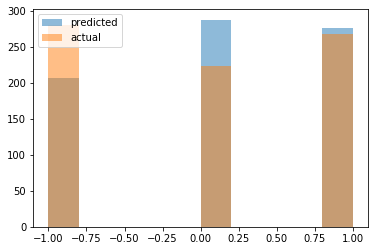

Features: [7, 5, 4, 8, 3, 1, 2]
Column Accuracy: 0.6297927461139896


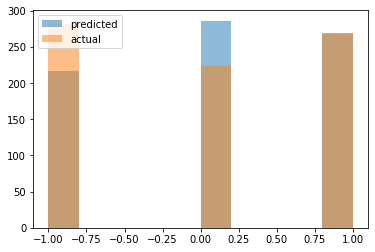

Features: [7, 5, 4, 8, 3, 1, 6]
Column Accuracy: 0.6507772020725389


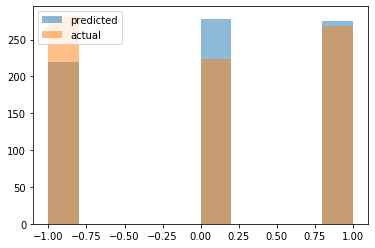

Features: [7, 5, 4, 8, 3, 1, 9]
Column Accuracy: 0.6230569948186528


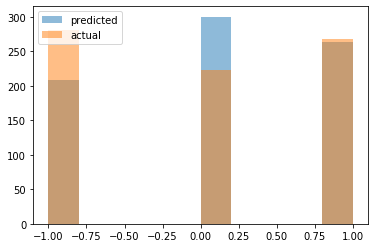

~~~ Choosing Max Cols: [6]
~~~ Max Accuracy: 0.6507772020725389
Remaining Columns: [[0], [2], [9]]
Features: [7, 5, 4, 8, 3, 1, 6, 0]
Column Accuracy: 0.6507772020725389


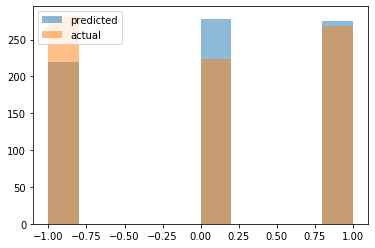

Features: [7, 5, 4, 8, 3, 1, 6, 2]
Column Accuracy: 0.6329015544041451


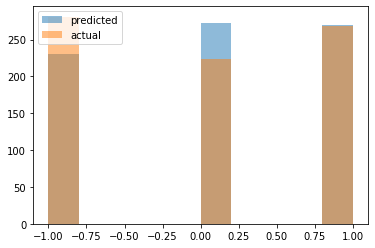

Features: [7, 5, 4, 8, 3, 1, 6, 9]
Column Accuracy: 0.6494818652849741


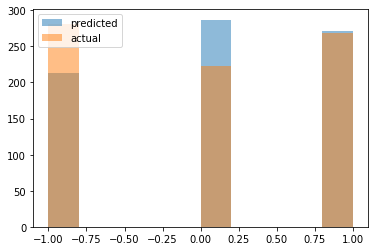

Adding [0] showed no improvement, stopping...
Best Columns found: [7, 5, 4, 8, 3, 1, 6]
For Period 4 Best Columns found: [7, 5, 4, 8, 3, 1, 6] With accuracy: 0.6507772020725389


In [563]:
"""combClass = GradientBoostingClassifier(learning_rate=.1, max_depth=3, max_leaf_nodes=50,
                                       n_estimators=200)
combClass.fit(combData.train_p3_x, combData.train_p3_y)
gb_shift_pred = combClass.predict(combData.test_p3_x)
shift_acc = accuracy_score(combData.test_p3_y, gb_shift_pred)
print("Period: " + str(i))
print("Shift Data Acc: " + str(shift_acc))
plt.hist(gb_shift_pred, alpha=0.5, label='predicted')
plt.hist(combData.test_p3_y, alpha=0.5, label='actual')
plt.legend(loc='best')
plt.show()"""

x_train = {1:"train_p1_xc", 2:"train_p2_xc", 3:"train_p3_xc", 4:"train_p4_xc"}
y_train = {1:"train_p1_y", 2:"train_p2_y", 3:"train_p3_y", 4:"train_p4_y"}
x_test = {1:"test_p1_xc", 2:"test_p2_xc", 3:"test_p3_xc", 4:"test_p4_xc"}
y_test = {1:"test_p1_y", 2:"test_p2_y", 3:"test_p3_y", 4:"test_p4_y"}

for p in range(1,5):
    col_pairs = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
    cols = []
    best_acc = 0
    print("Finding Features for Period " + str(p))
    for s in range(len(col_pairs)):
        max_acc = 0
        max_cols = []
        for t in col_pairs:
            tmp2_cols = []
            for m in cols:
                tmp2_cols.append(m)
            for k in t:
                tmp2_cols.append(k)
            print("Features: " + str(tmp2_cols))
            combData.chooseColumns(tmp2_cols)
            av_col_acc = 0
            for i in range(5):
                g_col = GradientBoostingClassifier(learning_rate=.1, max_depth=3, max_leaf_nodes=50,
                                                   n_estimators=200)
                g_col.fit(getattr(combData,x_train[p]), getattr(combData,y_train[p]))
                g_col_pred = g_col.predict(getattr(combData,x_test[p]))
                av_col_acc += accuracy_score(getattr(combData,y_test[p]), g_col_pred)
            col_acc = av_col_acc/5
            if col_acc > max_acc:
                max_acc = col_acc
                max_cols = t
            print("Column Accuracy: " + str(col_acc))
            plt.hist(g_col_pred, alpha=0.5, label='predicted')
            plt.hist(getattr(combData,y_test[p]), alpha=0.5, label='actual')
            plt.legend(loc='best')
            plt.show()
        # add max cols
        if best_acc >= max_acc:
            print("Adding " + str(max_cols) + " showed no improvement, stopping...")
            print("Best Columns found: " + str(cols))
            break
        
        for k in max_cols:
            cols.append(k)
        col_pairs.remove(max_cols)
        print("~~~ Choosing Max Cols: " + str(max_cols))
        print("~~~ Max Accuracy: " + str(max_acc))
        print("Remaining Columns: " + str(col_pairs))
        best_acc = max_acc
    print("For Period " + str(p) + " Best Columns found: " + str(cols) + " With accuracy: " + str(best_acc))